# **Chapter 1. Exploratory Data Analysis**

In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

# Standard library
from pathlib import Path

# Core scientific libraries
import numpy as np
import pandas as pd

# Statistical libraries
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = Path("data")
STATE_CSV = data_dir / "state.csv"
AIRPORT_DELAYS_CSV = data_dir / 'dfw_airline.csv'
SP500_DATA_CSV = data_dir / 'sp500_data.csv'
SP500_SECTORS_CSV = data_dir / 'sp500_sectors.csv'
KC_TAX_CSV = data_dir / 'kc_tax.csv'
LC_LOANS_CSV = data_dir / 'lc_loans.csv'
AIRLINE_STATS_CSV = data_dir / 'airline_stats.csv'

## **Estimates of Location**
### **Example: Location Estimates of Population and Murder Rates**

In [3]:
# Table 1-2
state = pd.read_csv(STATE_CSV)
state.head(8)

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA
5,Colorado,5029196,2.8,CO
6,Connecticut,3574097,2.4,CT
7,Delaware,897934,5.8,DE


In [4]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         50 non-null     object 
 1   Population    50 non-null     int64  
 2   Murder.Rate   50 non-null     float64
 3   Abbreviation  50 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


In [5]:
state['Population'].mean()

6162876.3

In [6]:
state['Population'].median()

4436369.5

In [7]:
# from scipy.stats import trim_mean

# Calculate the trimmed mean by trimming 10% from each end
trimmed = trim_mean(state['Population'], proportiontocut=0.1)

print(f"Trimmed mean (10%): {trimmed:.2f}")


Trimmed mean (10%): 4783697.12


📊 Pattern:
Mean > Trimmed Mean > Median

🧠 Interpretation:  
This suggests your data is **right-skewed** (positively skewed).

Here’s why:  
- The mean is sensitive to large values, so if it’s noticeably higher, there are probably a few large outliers pulling it up.
- The trimmed mean excludes those extremes, so it drops closer to the bulk of the data — but is still higher than the median.
- The median, being robust to outliers, stays centered on the bulk of values.

✅ Conclusion:
Your column likely has a long tail on the right, with high-value outliers inflating the mean.

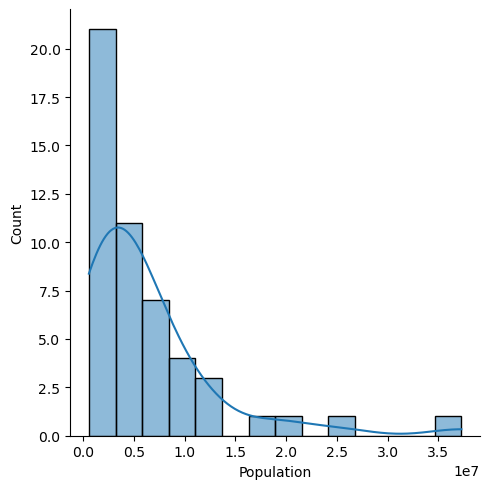

In [8]:
sns.displot(state['Population'], kde= True);

In [9]:
# 1. Weighted Mean: Use numpy.average()

values = state['Murder.Rate']
weights = state['Population']

weighted_mean = np.average(values, weights=weights)
weighted_mean

4.445833981123393

In [10]:
# 2. Weighted Median: There’s no built-in NumPy function, but you can use the wquantiles package
import wquantiles

# Compute weighted median
weighted_median = wquantiles.median(
    state['Murder.Rate'],     # your_column
    state['Population']       # your_weights
)
weighted_median
# This gives you the value where half the total weight is below, and half is above — just like a regular median, but accounting for weights.

4.4

## **Estimates of Variability**

In [11]:
# Standard Deviation:
state['Population'].std()

6848235.347401142

In [12]:
# Interquartile range (IQR)
state['Population'].quantile(0.75) - state['Population'].quantile(0.25)

4847308.0

In [13]:
# The median absolute deviation from the median (MAD)
#type(state['Population'])      #pandas.core.series.Series

print(robust.scale.mad(state['Population']))   # output: 3849876.1459979336

# Method 2 (manual)
# Step 1: Compute the median
median = state['Population'].median()

# Step 2: Compute the absolute deviations from the median
abs_dev = (state['Population'] - median).abs()

# Step 3: Compute the median of those absolute deviations
mad = abs_dev.median()

print("MAD:", mad)  #output: MAD: 2596702.0

#the difference between the two results comes from scaling.


3849876.1459979336
MAD: 2596702.0


**Understanding the Difference Between Manual MAD and `robust.scale.mad()`**

The difference between the two results comes from **scaling**.

**1. The Manual Method**  
Manual MAD calculation
<pre>median = state['Population'].median()
mad = (state['Population'] - median).abs().median()</pre>  


This gives you the **raw MAD**, which is the median absolute deviation — exactly as defined:

$$
\text{MAD} = \text{median} \left( |X_i - \text{median}(X)| \right)
$$

**Your result:** `2,596,702.0`

This is the **unscaled** MAD.  

**2. `robust.scale.mad()` from statsmodels**
<pre>
from statsmodels import robust
robust.scale.mad(state['Population'])
</pre>

This function returns a **scaled** version of MAD, specifically:

$$
\text{MAD}_{\text{scaled}} = \text{MAD} \times 1.4826
$$

Why? Because the scaled MAD is a robust estimator of the standard deviation assuming normality.

**Your result:**

$$
2,596,702 \times 1.4826 \approx 3,849,876.15
$$


**Summary Table**

| Method                | Output        | Scaled? | Purpose                                  |
|-----------------------|---------------|---------|------------------------------------------|
| Your manual method     | 2,596,702.0   | ❌ No   | Raw median absolute deviation             |
| `robust.scale.mad()`   | 3,849,876.15  | ✅ Yes  | Robust estimate of standard deviation σ (if data is normal) |


`statsmodels.robust.scale.mad()` = MAD × 1.4826

It's designed as a robust estimate of the standard deviation under the assumption of normality.

**Bottom line:** Both methods are correct — they just serve different purposes!


**Why Do We Scale MAD by 1.4826?**

It's absolutely right to question this:

> **Why do we apply a scaling factor derived from the normal distribution if the data might not be normal?**

Let’s unpack this carefully.  

**Why Multiply MAD by 1.4826?**

The constant **1.4826** comes from the standard normal distribution. It is the reciprocal of the median absolute deviation of a standard normal variable:

$$
\text{MAD}_{N(0,1)} \approx 0.67449 \quad \Rightarrow \quad \frac{1}{0.67449} \approx 1.4826
$$

So, if the underlying data is normal, then:

$$
\sigma \approx \text{MAD} \times 1.4826
$$

**So… why use this scaling at all?**  

You’re right: we can’t assume normality in every dataset. However:

**1. It gives a robust estimator of spread, even if not normal**  

- Standard deviation is very sensitive to outliers.  
- MAD is robust — it’s not thrown off by extreme values.  

Using:

$$
\hat{\sigma}_{\text{robust}} = \text{MAD} \times 1.4826
$$

gives a "robust version" of standard deviation that works reasonably well across many symmetric distributions.

It’s like saying:

> “This isn’t a perfect estimate of $\sigma$ if the data isn’t normal, but it’s better than using $\sigma$ itself when there are outliers.”

**2. It’s a convention — not a strict rule**  

- When people want a robust estimate of $\sigma$ , they often use scaled MAD — knowing it assumes approximate normality.  
- If your data is far from normal (e.g., very skewed or heavy-tailed), then don’t use 1.4826 — or even don’t scale MAD at all.

When **Not** to Use the Scaling

If your data is:

- Skewed  
- Heavy-tailed (e.g., t-distribution, Laplace)  
- Not symmetric  

Then:

- The scaling factor 1.4826 is no longer valid.  
- You may choose to:  
  - Leave MAD unscaled  
  - Use a different robust estimator (e.g., IQR / 1.349)  
  - Or estimate \(\sigma\) empirically another way

**Summary Table**

| Question                        | Answer                                                         |
|--------------------------------|----------------------------------------------------------------|
| Why is MAD scaled by 1.4826?   | To estimate $\sigma$ under normality                         |
| Can we always assume normality?| No — it’s an approximation                                     |
| What if data isn't normal?      | Then $\text{MAD} \times 1.4826$ may misrepresent $\sigma$  |
| Why still use it?               | It’s robust and better than $\sigma$ in presence of outliers — but use with care |


**Bottom line:** Scaling MAD by 1.4826 is a useful robust estimate of standard deviation *if* your data is roughly symmetric and near normal. Otherwise, consider alternative approaches.

---

In [14]:
print(robust.scale.mad(state['Population']))
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336
3849876.1459979336


### **Percentiles and Boxplots**

In [15]:
state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

In [16]:
# Table 1.4
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages).round(2))
df.index = [f'{int(p * 100)}%' for p in percentages]
print(df.transpose())
df

              5%   25%  50%   75%   95%
Murder.Rate  1.6  2.42  4.0  5.55  6.51


,Murder.Rate
5%,1.60
25%,2.42
50%,4.00
75%,5.55
95%,6.51


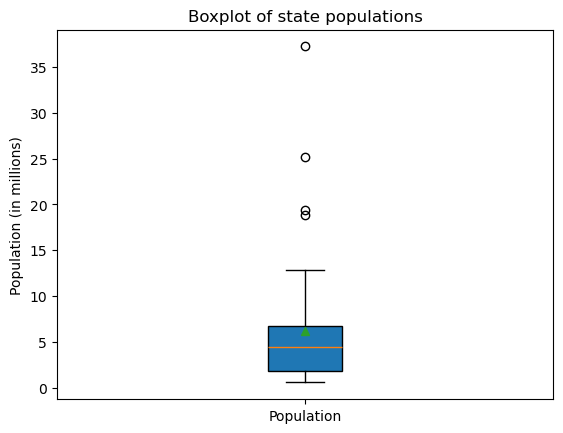

In [17]:
plt.boxplot(state['Population']/1_000_000,vert=True,patch_artist=True, showmeans=True)
plt.ylabel('Population (in millions)')
plt.xticks([1], ['Population'])
plt.title('Boxplot of state populations');

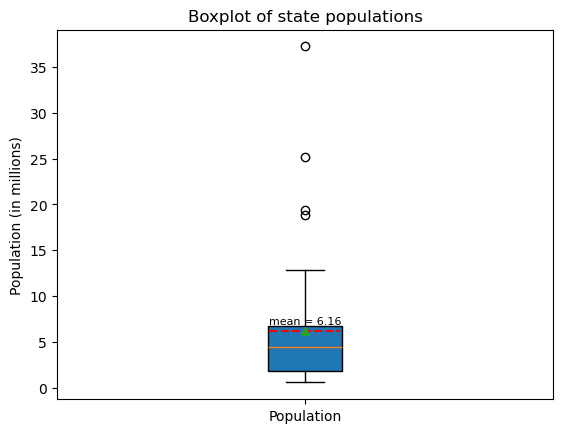

In [18]:
#Basic Matplotlib commands allow you to create a plot and we'll show you two ways of creating Matplotlib plots:
#1) Functional method
#2) Object oriented method (usually the better way)

# Functional method (the functional interface (also called the state-machine interface) in Matplotlib.):
data = state['Population'] / 1_000_000
plt.boxplot(data,
            vert=True,
            patch_artist=True,
            showmeans=True)
# Calculate and annotate mean
mean_pop = np.mean(data)
plt.hlines(mean_pop, 1 - 0.07, 1 + 0.07, colors='red', linestyles='dashed', label='Mean')
plt.text(1, mean_pop + 0.7, f"mean = {mean_pop:.2f}", ha="center", fontsize=8)
plt.ylabel('Population (in millions)')
# plt.xlabel('Population')
# Fix the '1' on the x-axis:
# The extra '1' on the x-axis is showing because matplotlib.pyplot.boxplot() assigns numeric tick labels by default (1 for one box). 
# Since you're plotting a single series, it assigns the position 1 automatically.
plt.xticks([1], ['Population'])  # Set label at position 1 to an empty string
plt.title('Boxplot of state populations');
# plt.grid(True)  # Optional, for better readability

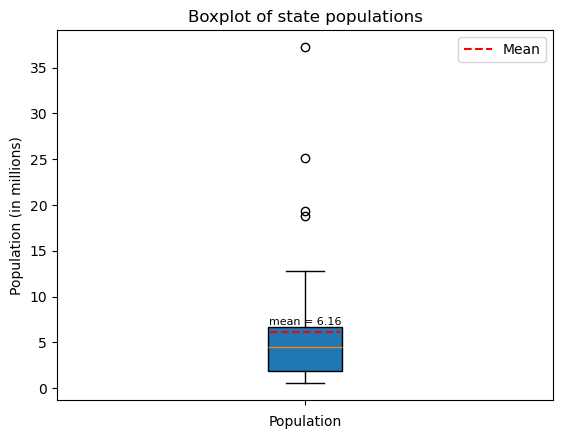

In [19]:
# Object oriented method (we're using the object-oriented interface, which is clean, modular, and scalable.):
fig, axes = plt.subplots()
data = state['Population'] / 1_000_000
axes.boxplot(data, vert=True, patch_artist=True, showmeans=False)

# Axis labels and title
axes.set_xlabel('Population')
axes.set_ylabel('Population (in millions)')
axes.set_title('Boxplot of state populations')

# Fix the default x-axis tick label ("1")
axes.set_xticks([1])
axes.set_xticklabels([''])  # or ['States'] if you want a label

# Calculate and annotate mean
mean_pop = np.mean(data)
axes.hlines(mean_pop, 1 - 0.07, 1 + 0.07, colors='red', linestyles='dashed', label='Mean')
axes.text(1, mean_pop + 0.7, f"mean = {mean_pop:.2f}", ha="center", fontsize=8)

# Add legend
axes.legend()

plt.show()

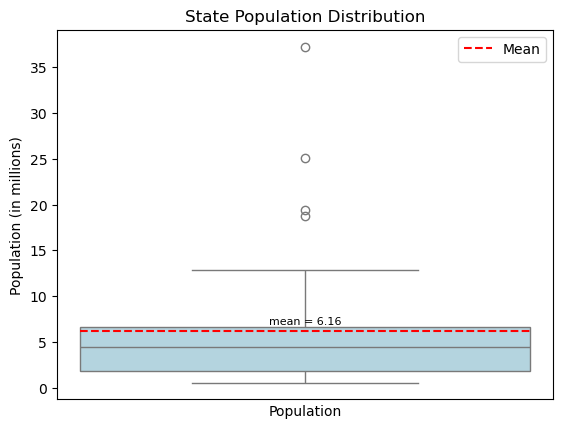

In [20]:
# Prepare data
state['Population_Millions'] = state['Population'] / 1_000_000

# Create plot
fig, ax = plt.subplots()
sns.boxplot(y='Population_Millions', data=state, ax=ax, color='lightblue',  width=0.04)

# Calculate and annotate mean
mean_pop = state['Population_Millions'].mean()
ax.hlines(mean_pop, 0-0.02, 0+0.02, colors='red', linestyles='dashed', label='Mean')
ax.text(0, mean_pop + 0.7, f"mean = {mean_pop:.2f}", ha="center", fontsize=8)

# Customize axes
ax.set_xlabel('Population')
ax.set_ylabel('Population (in millions)')
ax.set_title('State Population Distribution')
ax.set_xticks([])  # remove the default category label (e.g., "Population_Millions")

# Add legend
ax.legend()

plt.show();
'''
Think of fig, ax = plt.subplots() as you building a canvas and a frame, and then:
    sns.boxplot(..., ax=ax) means:
“Paint this plot inside the frame I give you.”
Without ax=ax, Seaborn will just grab a default empty frame and draw in that.
''';

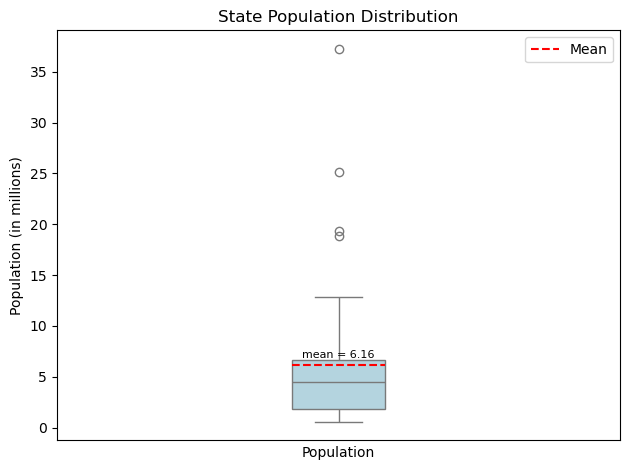

In [21]:
#the box still looks wide because Seaborn automatically scales the plot canvas regardless of the box width, especially when there’s only one category.
# To make the box narrower visually, we need to shrink the entire x-axis range to tightly frame the box. Here’s how you can fix it:

# Assume state['Population_Millions'] already exists
fig, ax = plt.subplots()  # Make the plot narrower overall

# Draw the boxplot with narrow width
sns.boxplot(y='Population_Millions', data=state, ax=ax, color='lightblue', width=0.1)

# Get x position of the box
x_pos = ax.get_xticks()[0]

# Calculate and annotate mean
mean_pop = state['Population_Millions'].mean()
ax.hlines(mean_pop, x_pos - 0.05, x_pos + 0.05, colors='red', linestyles='dashed', label='Mean')
ax.text(x_pos, mean_pop + 0.7, f"mean = {mean_pop:.2f}", ha="center", fontsize=8)

# Tweak axis appearance
ax.set_xlim(x_pos - 0.3, x_pos + 0.3)  # Shrink x-axis range to match box width
ax.set_xlabel('Population')
ax.set_ylabel('Population (in millions)')
ax.set_title('State Population Distribution')
ax.set_xticks([])

ax.legend()
plt.tight_layout()
plt.show()




Text(1, 2.4363694999999996, 'median = 4.44')

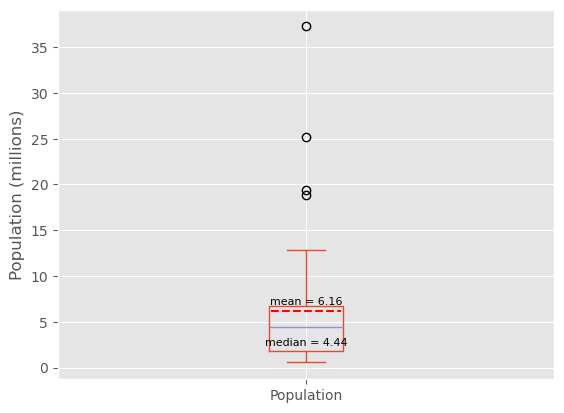

In [22]:
#We're using Pandas' built-in plotting functionality, which is built on top of Matplotlib.
# plt.style.use('bmh')
plt.style.use('ggplot')
ax = (state['Population']/1_000_000).plot.box()
ax.set_ylabel('Population (millions)')
# Get x position of the box
x_pos = ax.get_xticks()[0]

# Calculate and annotate mean
mean_pop = state['Population_Millions'].mean()
median_pop = state['Population_Millions'].median()
ax.hlines(mean_pop, x_pos - 0.07, x_pos + 0.07, colors='red', linestyles='dashed', label='Mean')
ax.text(x_pos, mean_pop + 0.7, f"mean = {mean_pop:.2f}", ha="center", fontsize=8)
ax.text(x_pos, median_pop - 2, f"median = {median_pop:.2f}", ha="center", fontsize=8)

**What is box plot?**  
Box Plot Explained with Matplotlib  
<pre>
plt.boxplot(data, vert=True, patch_artist=True, showmeans=True)
plt.show()
</pre>

- **`data`**: The dataset(s) to be plotted as box plots.
- **`vert=True`**: Boxes are vertical (default behavior).
- **`patch_artist=True`**: Fills the boxes with color, making them easier to visually distinguish.
- **`showmeans=True`**: Displays the mean value as a marker (usually a triangle).  

A box plot summarizes data distribution by showing:

- **Median (Q2)**: The middle line inside the box represents the median value of the dataset (the middle value when data is sorted).
- **Interquartile Range (IQR)**: The box spans from the first quartile (Q1, 25th percentile) to the third quartile (Q3, 75th percentile), covering the middle 50% of the data.
- **Whiskers**: Lines extending from the box to the smallest and largest values within 1.5×IQR from Q1 and Q3, representing the bulk of the data.
- **Outliers**: Data points beyond the whiskers are considered outliers and plotted as individual points.

**Why 1.5×IQR for Whiskers?**

- The **IQR** is the range between Q1 and Q3, representing the middle 50% of the data.
- The multiplier **1.5×IQR** is an empirical rule to identify unusually distant values (outliers).

**The rule:**

- Anything **below**: Q1 − 1.5×IQR  
- Anything **above**: Q3 + 1.5×IQR  
is considered an **outlier**.

**Why 1.5?**

- It’s not a mathematically derived constant but an empirical rule that works well in practice.
- Balances sensitivity (detecting outliers) and robustness (not flagging too many normal points).
- Widely accepted and effective across many datasets.

**Additional Notes**

- When the **mean** is shown (often as a triangle), the line representing the mean usually passes through the center of the triangle.
- The **width** of each box typically has no meaning in a standard box plot.
- Box plots enable quick visual comparison of spread, center, and outliers across multiple datasets.

---

In [23]:
state['Population_Millions'].max()

37.253956

In [24]:
state['Population_Millions'].min()

0.563626

### **requency Table and Histograms**  
The `cut` method in pandas is used to split a dataset into bins. It accepts several arguments to customize the binning process. The following code creates equally sized bins. The `value_counts` method then returns a frequency table.

In [25]:
binnedPopulation = pd.cut(state['Population'], 10)
binnedPopulation.value_counts()

Population
(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: count, dtype: int64

In [26]:
binnedPopulation.value_counts().index

CategoricalIndex([  (526935.67, 4232659.0],   (4232659.0, 7901692.0],
                   (7901692.0, 11570725.0], (11570725.0, 15239758.0],
                  (15239758.0, 18908791.0], (18908791.0, 22577824.0],
                  (22577824.0, 26246857.0], (33584923.0, 37253956.0],
                  (26246857.0, 29915890.0], (29915890.0, 33584923.0]],
                 categories=[(526935.67, 4232659.0], (4232659.0, 7901692.0], (7901692.0, 11570725.0], (11570725.0, 15239758.0], ..., (22577824.0, 26246857.0], (26246857.0, 29915890.0], (29915890.0, 33584923.0], (33584923.0, 37253956.0]], ordered=True, dtype='category', name='Population')

In [27]:
# state['Population'].value_counts().shape    #(50,)
state['Population'].value_counts()

Population
4779736     1
12702379    1
2700551     1
1316470     1
8791894     1
2059179     1
19378102    1
9535483     1
672591      1
11536504    1
3751351     1
3831074     1
1052567     1
710231      1
4625364     1
814180      1
6346105     1
25145561    1
2763885     1
625741      1
8001024     1
6724540     1
1852994     1
5686986     1
1826341     1
989415      1
5988927     1
2967297     1
6392017     1
2915918     1
37253956    1
5029196     1
3574097     1
897934      1
18801310    1
9687653     1
1360301     1
1567582     1
12830632    1
6483802     1
3046355     1
2853118     1
4339367     1
4533372     1
1328361     1
5773552     1
6547629     1
9883640     1
5303925     1
563626      1
Name: count, dtype: int64

In [28]:
state['Population']

0      4779736
1       710231
2      6392017
3      2915918
4     37253956
5      5029196
6      3574097
7       897934
8     18801310
9      9687653
10     1360301
11     1567582
12    12830632
13     6483802
14     3046355
15     2853118
16     4339367
17     4533372
18     1328361
19     5773552
20     6547629
21     9883640
22     5303925
23     2967297
24     5988927
25      989415
26     1826341
27     2700551
28     1316470
29     8791894
30     2059179
31    19378102
32     9535483
33      672591
34    11536504
35     3751351
36     3831074
37    12702379
38     1052567
39     4625364
40      814180
41     6346105
42    25145561
43     2763885
44      625741
45     8001024
46     6724540
47     1852994
48     5686986
49      563626
Name: Population, dtype: int64

In [29]:
pd.cut(state['Population'], 10)

0       (4232659.0, 7901692.0]
1       (526935.67, 4232659.0]
2       (4232659.0, 7901692.0]
3       (526935.67, 4232659.0]
4     (33584923.0, 37253956.0]
5       (4232659.0, 7901692.0]
6       (526935.67, 4232659.0]
7       (526935.67, 4232659.0]
8     (15239758.0, 18908791.0]
9      (7901692.0, 11570725.0]
10      (526935.67, 4232659.0]
11      (526935.67, 4232659.0]
12    (11570725.0, 15239758.0]
13      (4232659.0, 7901692.0]
14      (526935.67, 4232659.0]
15      (526935.67, 4232659.0]
16      (4232659.0, 7901692.0]
17      (4232659.0, 7901692.0]
18      (526935.67, 4232659.0]
19      (4232659.0, 7901692.0]
20      (4232659.0, 7901692.0]
21     (7901692.0, 11570725.0]
22      (4232659.0, 7901692.0]
23      (526935.67, 4232659.0]
24      (4232659.0, 7901692.0]
25      (526935.67, 4232659.0]
26      (526935.67, 4232659.0]
27      (526935.67, 4232659.0]
28      (526935.67, 4232659.0]
29     (7901692.0, 11570725.0]
30      (526935.67, 4232659.0]
31    (18908791.0, 22577824.0]
32     (

In [30]:
# Table 1.5
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation', observed=False):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

In [31]:
state.head()

,State,Population,Murder.Rate,Abbreviation,Population_Millions
0,Alabama,4779736,5.7,AL,4.779736
1,Alaska,710231,5.6,AK,0.710231
2,Arizona,6392017,4.7,AZ,6.392017
3,Arkansas,2915918,5.6,AR,2.915918
4,California,37253956,4.4,CA,37.253956


In [32]:
state.sort_values(by='Population').iloc[-1]['State']

'California'

In [33]:
state[state['Population'] == state['Population'].min()]['State']

49    Wyoming
Name: State, dtype: object

In [34]:
state_copy = state.copy()
state_copy['binnedPopulation'] = binnedPopulation
state_copy = state_copy.sort_values(by='Population')    #This makes sure states are sorted by their population before grouping.
groups = []
for group, subset in state_copy.groupby(by='binnedPopulation', observed=False):
    groups.append({
        'BinRange': group,
        'Count': len(subset), #len(subset): Returns the number of rows in the DataFrame subset.
        'States': ','.join(subset.Abbreviation)
    })
'''
This groups the state_copy DataFrame by the new 'binnedPopulation' column.
For each group:
    'group' is the bin label (like (4000000, 8000000])
    subset is a DataFrame, which is a filtered view of 'state_copy' that includes all columns, and only those rows where 'binnedPopulation' == group.

Then we create a dictionary with:
    'BinRange': the bin interval
    'Count': how many states are in this bin
    'States': a comma-separated string of state abbreviations in that bin

All these dictionaries are appended to a list called groups.
'''
# len(groups) #10
a =pd.DataFrame(groups)
a
# len(a) #10

,BinRange,Count,States
0,"(526935.67, 4232659.0]",24,"WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N..."
1,"(4232659.0, 7901692.0]",14,"KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA"
2,"(7901692.0, 11570725.0]",6,"VA,NJ,NC,GA,MI,OH"
3,"(11570725.0, 15239758.0]",2,"PA,IL"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


In [35]:
state_copy.head(2)

,State,Population,Murder.Rate,Abbreviation,Population_Millions,binnedPopulation
49,Wyoming,563626,2.7,WY,0.563626,"(526935.67, 4232659.0]"
44,Vermont,625741,1.6,VT,0.625741,"(526935.67, 4232659.0]"


array([[<Axes: title={'center': 'Population'}>]], dtype=object)

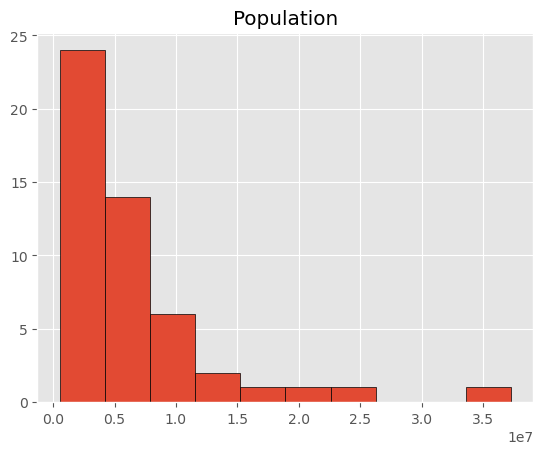

In [36]:
state_copy.hist('Population',edgecolor='black')
#The default number of bins in pandas.DataFrame.hist() — which internally uses matplotlib.pyplot.hist() — is:10 bins

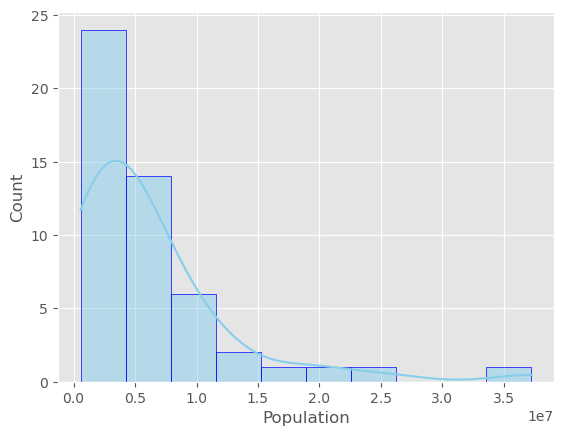

In [37]:
sns.histplot(data=state_copy, x='Population', bins=10, kde=True, color='skyblue', edgecolor='blue');

Text(0.5, 0, 'Population (millions)')

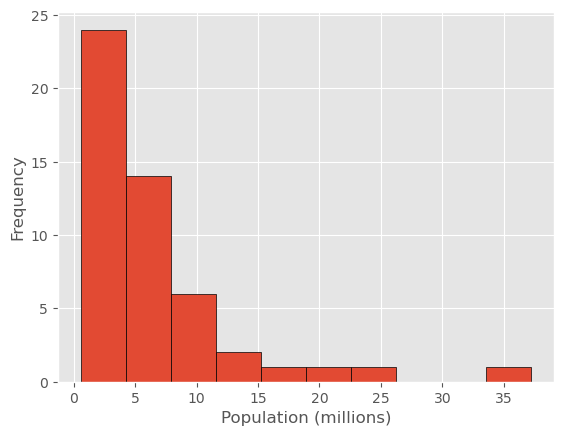

In [38]:
ax = state['Population_Millions'].plot.hist(bins = 10, edgecolor='black')
ax.set_xlabel("Population (millions)")
# type(ax)    #matplotlib.axes._axes.Axes

In [39]:
# To measure the skewness and kurtosis of the 'Population' column in state_copy, you can use built-in pandas or scipy methods — completely separate from the histogram plot. Here's how:

# ✅ 1. Skewness (asymmetry of the distribution)
state_copy['Population'].skew()
# Positive → right-skewed (long tail to the right)
# Negative → left-skewed

# ✅ 2. Kurtosis (tailedness or peakedness)
state_copy['Population'].kurt()
# A normal distribution has kurtosis ≈ 0 (in pandas)
# High kurtosis → heavy tails (outliers)
# Low kurtosis → light tails

# ✅ Full Example:
skew_val = state_copy['Population'].skew()
kurt_val = state_copy['Population'].kurt()

print(f"Skewness: {skew_val:.2f}")
print(f"Kurtosis: {kurt_val:.2f}")


# 📌 Optional:
# If you want more robust kurtosis (Fisher or Pearson) or adjusted skew, you can use scipy.stats:

from scipy.stats import skew, kurtosis

print(skew(state_copy['Population']))       # same as pandas
print(kurtosis(state_copy['Population']))   # by default gives Fisher (normal = 0)
print(kurtosis(state_copy['Population'], fisher=False))  # Pearson kurtosis (normal = 3)


Skewness: 2.64
Kurtosis: 8.72
2.5626855429174085
7.7563388662394335
10.756338866239433


**Understanding Skewness and Kurtosis in U.S. State Populations**

**1. Skewness**(asymmetry of the distribution)  

**Reference Point:** 
- A perfectly symmetric (normal) distribution has skewness **0**.

**Interpretation Guide:**

| Skewness Value | Interpretation                   |
|----------------|---------------------------------|
| ≈ 0            | Symmetric                       |
| ±0.5 or less   | Fairly symmetrical              |
| ±1.0 or more   | Moderately skewed               |
| ±2.0 or more   | Highly skewed                  |
| ≥ 2.5          | Very highly skewed (rare in natural data) |

➡️ Your value of **2.64** indicates a **very high right skew**.  

**2. Kurtosis (pandas default: Fisher’s definition)**(tailedness or peakedness)  

**Reference Point:**  
- A normal distribution has kurtosis = **0** (Fisher’s definition).
- In Pearson's definition (used by `scipy.stats.kurtosis(..., fisher=False)`), normal kurtosis = **3**.

**Interpretation Guide (Fisher's):**  

| Kurtosis Value | Interpretation                  |
|----------------|--------------------------------|
| ≈ 0            | Normal tails                   |
| 1–3            | Moderate heavy tails           |
| > 3            | Heavy tails / Outliers         |
| > 5            | Very peaked and heavy-tailed   |

➡️ Your kurtosis of **8.72** indicates a **very high kurtosis**, meaning a sharp peak and many outliers.


**Skewness: 2.64**

- A positive skewness means the distribution is **right-skewed**.
- Most states have relatively **low populations**.
- A few states (California, Texas, New York) have **very large populations**, creating a long tail on the right.
- This matches the histogram: a dense cluster of bars on the left, with a few stretching far to the right.



**Kurtosis: 8.72**

- Indicates **heavy tails** and significant outliers.
- Distribution is more **peaked in the center** with extreme values in the tails compared to a normal distribution.



**Summary Table**

| Metric   | Normal Value | Your Value | Interpretation               |
|----------|--------------|------------|------------------------------|
| Skewness | 0            | 2.64       | Very right-skewed            |
| Kurtosis | 0 (Fisher)   | 8.72       | Heavy tails / many outliers  |

These values strongly suggest your data is **non-normal**, influenced by extreme population differences across U.S. states.


**Summary**

> The population distribution among U.S. states is heavily skewed to the right, with a few very large states stretching the scale. It also shows high kurtosis, meaning there are pronounced outliers and the bulk of states are tightly clustered at lower population levels.

---


### **Density Estimates**  
Density is an alternative to histograms that can provide more insight into the distribution of the data values. Use the argument `bw_method` to control the smoothness of the density curve.

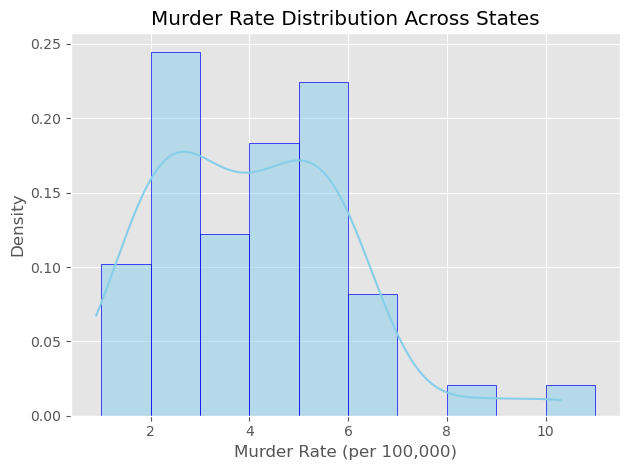

In [40]:
sns.histplot(data=state_copy, x='Murder.Rate', bins=range(1,12), kde=True, color='skyblue',stat= 'density', edgecolor='blue');

# Add labels and title using matplotlib
plt.title('Murder Rate Distribution Across States')
plt.xlabel('Murder Rate (per 100,000)')
plt.ylabel('Density')

plt.tight_layout()  # Optional: improves spacing

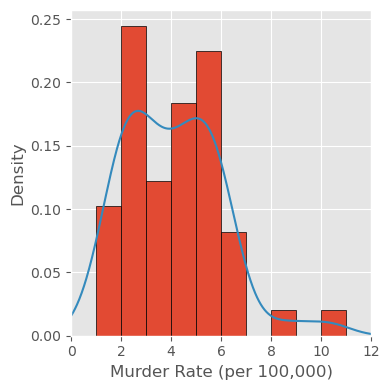

In [41]:
# We first plot a normalized histogram:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], 
                                    bins=range(1,12), figsize=(4, 4), edgecolor='black')

#Then overlay a kernel density estimate (KDE):
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')
'''
❓Can you use bw_method?
Yes, but only on the .plot.density() part, not on .plot.hist().

✅ Correct usage:
state['Murder.Rate'].plot.density(ax=ax, bw_method=0.3)
bw_method controls the bandwidth of the KDE (smoothing).
Lower values (e.g., 0.2) give a wigglier curve.
Higher values (e.g., 1.0) give a smoother curve.
'''
plt.tight_layout()
plt.show()

## **Exploring Binary and Categorical Data**

In [42]:
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
dfw

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


In [43]:
dfw.values.sum()

279126.05000000005

In [44]:
# Table 1-6
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
100 * dfw / dfw.values.sum()

,Carrier,ATC,Weather,Security,Inbound
0,23.022989,30.400781,4.025214,0.122937,42.428079


In [45]:
dfw

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


In [46]:
dfw.transpose()

,0
Carrier,64263.16
ATC,84856.50
Weather,11235.42
Security,343.15
Inbound,118427.82


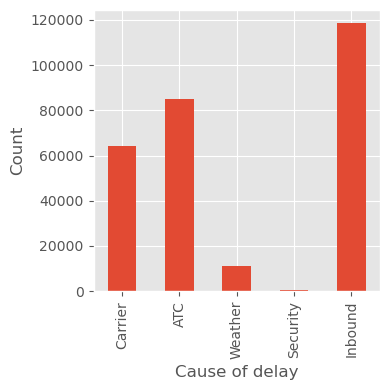

In [47]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [48]:
import cufflinks as cf
from plotly.offline import iplot

# Enable offline mode for Plotly
cf.go_offline()
# Transpose and plot
dfw.iplot(kind='bar', title='Delays by Cause', xTitle='Cause', yTitle='Delay Count')

In [49]:
dfw

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


In [50]:
import pandas as pd
import cufflinks as cf
from plotly.offline import iplot

# Activate Plotly in offline mode
cf.go_offline()


# Transpose to make each category a column (so each bar gets its own color)
dfw_transposed = dfw.transpose()
dfw_transposed.columns = ['Delays']
dfw_transposed = dfw_transposed.transpose()

# Plot with .iplot()
dfw_transposed.iplot(
    kind='bar',
    barmode='group',    #The part of our code that causes each bar to have a different color
    colorscale='Set2',  # try 'paired', 'Set1', 'Pastel1', etc. 
    title='Delays by Cause at DFW Airport',
    xTitle='Cause of Delay',
    yTitle='Delay Count',
    showlegend=True
)

In [51]:
df = pd.DataFrame({
    'Carrier': [64263.16],
    'ATC': [84856.5],
    'Weather': [11235.42],
    'Security': [343.15],
    'Inbound': [118427.82]
})
df.T

,0
Carrier,64263.16
ATC,84856.50
Weather,11235.42
Security,343.15
Inbound,118427.82


In [52]:
dfw.transpose()

,0
Carrier,64263.16
ATC,84856.50
Weather,11235.42
Security,343.15
Inbound,118427.82


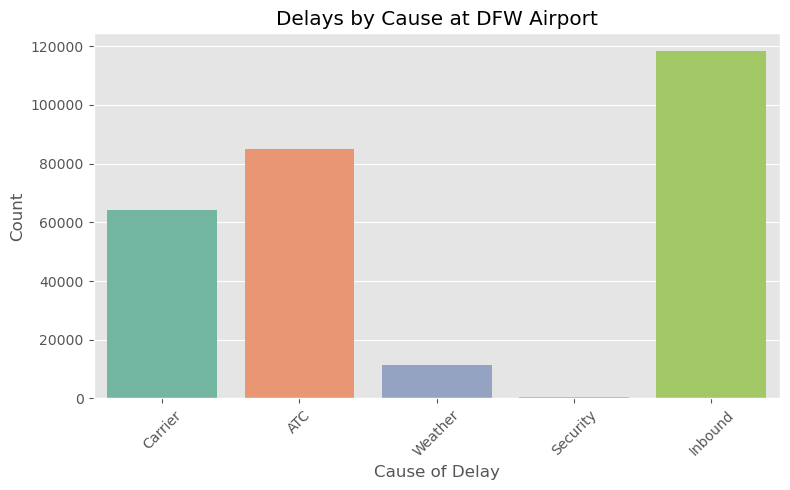

,Cause of Delay,Count
0,Carrier,64263.16
1,ATC,84856.50
2,Weather,11235.42
3,Security,343.15
4,Inbound,118427.82


In [53]:
# Seaborn Version:
dfw_long = dfw.transpose().reset_index()
dfw_long.columns = ['Cause of Delay', 'Count']

# Plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x='Cause of Delay', y='Count', data=dfw_long,hue='Cause of Delay', palette='Set2')

# Customize
plt.title('Delays by Cause at DFW Airport')
plt.xlabel('Cause of Delay')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
dfw_long

In [54]:
dfw.iloc[0]

Carrier      64263.16
ATC          84856.50
Weather      11235.42
Security       343.15
Inbound     118427.82
Name: 0, dtype: float64

In [55]:
dfw.iloc[0].index

Index(['Carrier', 'ATC', 'Weather', 'Security', 'Inbound'], dtype='object')

In [56]:
dfw.iloc[0].values

array([ 64263.16,  84856.5 ,  11235.42,    343.15, 118427.82])

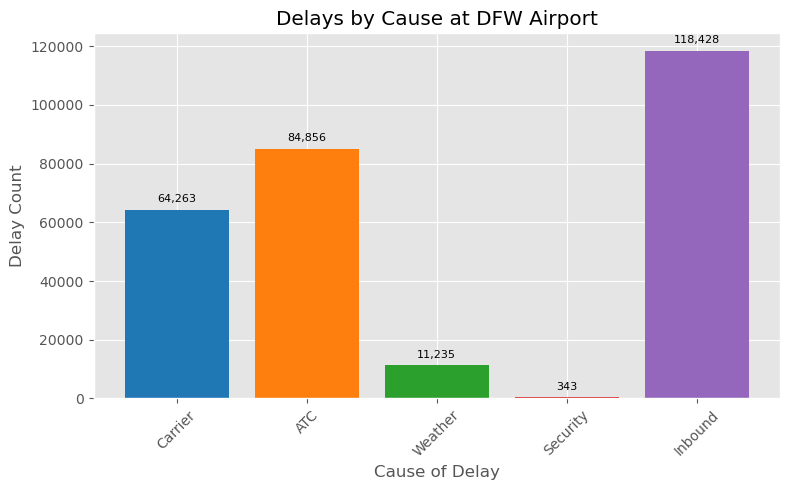

In [57]:
#Matplotlib version:

# Prepare data for plotting
delays = dfw.iloc[0]  # extract the row as a Series
categories = delays.index
values = delays.values

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add title and labels
plt.title('Delays by Cause at DFW Airport')
plt.xlabel('Cause of Delay')
plt.ylabel('Delay Count')
plt.xticks(rotation=45)

# Optional: Add value labels on top of bars
for bar in bars:    #Loops through each bar in the list of bar objects returned by plt.bar().
    height = bar.get_height()   #Gets the height of the current bar, which corresponds to the value (y-axis) being plotted (i.e., the delay count).
    plt.text(bar.get_x() + bar.get_width()/2, height + 2000, f'{height:,.0f}', ha='center', va='bottom', fontsize=8)
'''
bar.get_x()
This gives the x-coordinate of the left edge of the bar.

bar.get_width()
This returns the width of the bar.

bar.get_x() + bar.get_width()/2
This calculates the center point of the bar:

It moves from the left edge to halfway across the width.

This ensures your label (text) is centered horizontally above the bar.
'''
plt.tight_layout()
plt.show()

In [58]:

sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0) # the argument index_col=0 tells Pandas to use the first column (column at position 0) in the CSV file as the row index (i.e., the DataFrame’s index), rather than treating it as a normal data column.

In [59]:
sp500_sym.head(2)

,sector,sector_label,sub_sector,symbol
0,information_technology,Technology,data_processing_&_outsourced_services,ADS
1,information_technology,Technology,systems_software,CA


In [60]:
sp500_px.head(2)

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.0,0.060124,-0.022100,0.0,0.0,0.018897,0.007368,0.092165,0.259140,-0.007105,...,0.0,0.0,0.34716,0.0,0.04167,0.00000,0.015564,1.75,0.125,0.0
1993-02-01,0.0,-0.180389,0.027621,0.0,0.0,0.018889,0.018425,0.115207,-0.100775,0.063893,...,0.0,0.0,-0.23144,0.0,0.00000,-0.01041,0.007782,1.25,0.125,0.0


In [61]:
sp500_sym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sector        517 non-null    object
 1   sector_label  517 non-null    object
 2   sub_sector    517 non-null    object
 3   symbol        517 non-null    object
dtypes: object(4)
memory usage: 16.3+ KB


In [62]:
sp500_px.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5647 entries, 1993-01-29 to 2015-07-01
Columns: 517 entries, ADS to HSIC
dtypes: float64(517)
memory usage: 22.3+ MB


In [63]:
sp500_sym['sector'].value_counts()

sector
financials                     88
consumer_discretionary         84
industrials                    68
information_technology         66
health_care                    56
energy                         40
consumer_staples               36
utilities                      29
materials                      28
etf                            17
telecommunications_services     5
Name: count, dtype: int64

In [64]:
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']
type(telecomSymbols)    #pandas.core.series.Series
telecomSymbols

332       T
333     CTL
334     FTR
335      VZ
336    LVLT
Name: symbol, dtype: object

In [65]:
sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
...,...,...,...,...,...
2015-06-25,0.049342,-1.600000,-0.040000,-0.187790,-0.330002
2015-06-26,-0.256586,0.039999,-0.070000,0.029650,-0.739998
2015-06-29,-0.098685,-0.559999,-0.060000,-0.504063,-1.360000
2015-06-30,-0.503298,-0.420000,-0.070000,-0.523829,0.199997


In [66]:
# Table 1-7
# Determine telecommunications symbols
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()

,T,CTL,FTR,VZ,LVLT
T,1.000000,0.474683,0.327767,0.677612,0.278626
CTL,0.474683,1.000000,0.419757,0.416604,0.286665
FTR,0.327767,0.419757,1.000000,0.287386,0.260068
VZ,0.677612,0.416604,0.287386,1.000000,0.242199
LVLT,0.278626,0.286665,0.260068,0.242199,1.000000


In [67]:
telecom

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
...,...,...,...,...,...
2015-06-25,0.049342,-1.600000,-0.040000,-0.187790,-0.330002
2015-06-26,-0.256586,0.039999,-0.070000,0.029650,-0.739998
2015-06-29,-0.098685,-0.559999,-0.060000,-0.504063,-1.360000
2015-06-30,-0.503298,-0.420000,-0.070000,-0.523829,0.199997


In [68]:
etfsSymbols = sp500_sym[sp500_sym['sector'] == 'etf']['symbol']
etfs = sp500_px.loc[sp500_px.index >= '2012-07-01', etfsSymbols]
etfs.info()
etfscorr = etfs.corr()
etfscorr

<class 'pandas.core.frame.DataFrame'>
Index: 754 entries, 2012-07-02 to 2015-07-01
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLI     754 non-null    float64
 1   QQQ     754 non-null    float64
 2   SPY     754 non-null    float64
 3   DIA     754 non-null    float64
 4   GLD     754 non-null    float64
 5   VXX     754 non-null    float64
 6   USO     754 non-null    float64
 7   IWM     754 non-null    float64
 8   XLE     754 non-null    float64
 9   XLY     754 non-null    float64
 10  XLU     754 non-null    float64
 11  XLB     754 non-null    float64
 12  XTL     754 non-null    float64
 13  XLV     754 non-null    float64
 14  XLP     754 non-null    float64
 15  XLF     754 non-null    float64
 16  XLK     754 non-null    float64
dtypes: float64(17)
memory usage: 106.0+ KB


,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
XLI,1.000000,0.785865,0.888865,0.869680,0.056554,-0.468196,0.236881,0.782380,0.650054,0.798080,0.380809,0.784144,0.374000,0.663022,0.600424,0.787340,0.777773
QQQ,0.785865,1.000000,0.908995,0.834440,0.043553,-0.470555,0.199492,0.810158,0.560044,0.839701,0.346667,0.713463,0.421790,0.775392,0.614806,0.752771,0.945126
SPY,0.888865,0.908995,1.000000,0.953726,0.078722,-0.547074,0.272069,0.833937,0.713300,0.887028,0.481928,0.826053,0.406181,0.811269,0.744466,0.883616,0.886588
DIA,0.869680,0.834440,0.953726,1.000000,0.051523,-0.511327,0.256793,0.758012,0.658311,0.847043,0.463364,0.787415,0.383928,0.771044,0.753725,0.860556,0.842757
GLD,0.056554,0.043553,0.078722,0.051523,1.000000,-0.107488,0.216563,0.070110,0.188625,0.017467,0.121611,0.184366,-0.042233,-0.010200,0.033047,0.043039,0.053022
VXX,-0.468196,-0.470555,-0.547074,-0.511327,-0.107488,1.000000,-0.195397,-0.448942,-0.448474,-0.474756,-0.260395,-0.470890,-0.205661,-0.380925,-0.416913,-0.514365,-0.477258
USO,0.236881,0.199492,0.272069,0.256793,0.216563,-0.195397,1.000000,0.249799,0.525943,0.183275,0.113182,0.324166,0.078796,0.119500,0.116857,0.221760,0.225962
IWM,0.782380,0.810158,0.833937,0.758012,0.070110,-0.448942,0.249799,1.000000,0.586991,0.779750,0.325003,0.701533,0.387274,0.664288,0.537065,0.756282,0.760438
XLE,0.650054,0.560044,0.713300,0.658311,0.188625,-0.448474,0.525943,0.586991,1.000000,0.578956,0.337942,0.689778,0.260463,0.454457,0.413486,0.599129,0.559324
XLY,0.798080,0.839701,0.887028,0.847043,0.017467,-0.474756,0.183275,0.779750,0.578956,1.000000,0.366827,0.721232,0.370299,0.702860,0.663055,0.782053,0.772189


Due to the large number of columns in this table, looking at the correlation matrix is cumbersome and it's more convenient to plot the correlation as a heatmap. The seaborn package provides a convenient implementation for heatmaps.

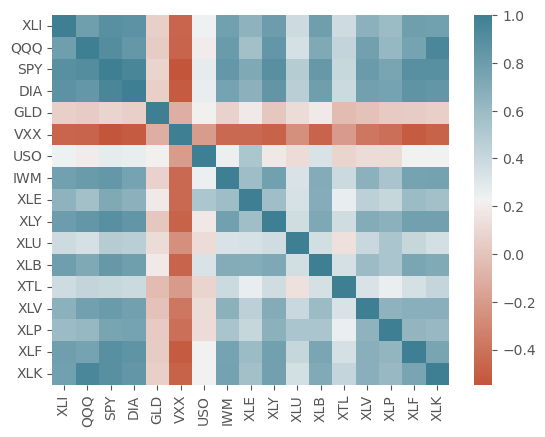

In [69]:
#Version 1: Without explicit axes (Seaborn handle everything implicitly.)
sns.heatmap(etfscorr, cmap=sns.diverging_palette(20, 220, as_cmap=True));

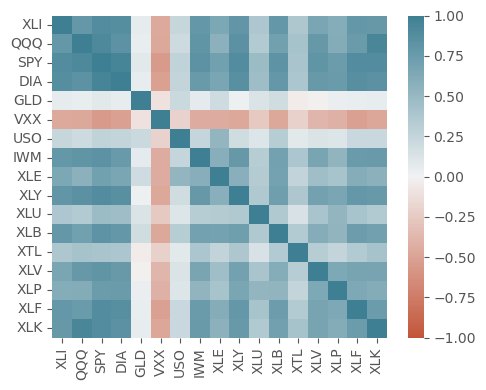

In [70]:
#Version 2: With fig and ax
fig, ax = plt.subplots(figsize=(5, 4)) # Create a figure and axes object
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax) # Draw the heatmap on that specific axes
'''
Who handles what?
Matplotlib handles:
    Creating the Figure and Axes objects (plt.subplots)
    Layout and rendering (tight_layout(), show())
    Under-the-hood plotting mechanics
Seaborn handles:
    High-level plotting logic (like calculating color scales, drawing the heatmap)
    But draws the actual plot using the Matplotlib Axes you provided (ax=ax)
'''
plt.tight_layout()
plt.show()

The above heatmap works when you have color. For the greyscale images, as used in the book, we need to visualize the direction as well. The following code shows the strength of the correlation using ellipses.

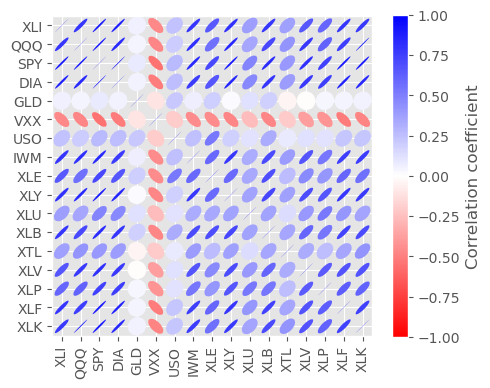

In [71]:
from matplotlib.collections import EllipseCollection    #A Matplotlib class for drawing multiple ellipses efficiently.
from matplotlib.colors import Normalize     #Scales values to the range [0, 1] or a specified range — used here to color-code correlation values from -1 to +1.

#This code defines and uses a custom plotting function called plot_corr_ellipses() to visualize a correlation matrix as a grid of ellipses, where each ellipse's orientation, shape, and color reflect the strength and direction of correlation between variables:
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    '''
    Defines a function to plot a correlation matrix visually using ellipses.
    figsize: optional figure size.
    **kwargs: lets you pass additional style arguments (e.g., colormap).
    '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    '''
    Converts input data (can be a DataFrame) to a NumPy 2D array M.
    Validates that the input is two-dimensional — required for a matrix plot.
    '''
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'}) #Creates a figure and an axis with equal aspect ratio so ellipses are not distorted.
    '''
    subplot_kw={'aspect': 'equal'}
    you are telling Matplotlib:
        “One unit on the x-axis should be the same length as one unit on the y-axis.”
        This ensures that shapes like ellipses or circles are not stretched. If your data ranges differently on each axis, without this, a circle could look like an oval, or an ellipse like a pancake.
    '''
    
    ax.set_xlim(-0.5, M.shape[1] - 0.5)     #M.shape is the shape of the correlation matrix (e.g., 5×5). set_xlim and set_ylim: Position ellipses in a grid from 0 to n-1, with slight padding on the edges (-0.5 to center ellipses).
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()   #invert_yaxis(): Flips the y-axis so the first variable appears at the top (just like standard correlation matrices).

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    # This code creates a collection of ellipses that visually represent the correlation coefficients in a matrix—how strong and in what direction (positive/negative) each pair of variables is correlated.
    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)
    '''
    ✅ EllipseCollection(...)
        This creates multiple ellipses at once, where each ellipse's:
            size,
            orientation, and    
            color
        are based on the correlation values from the matrix M.
        Think of this as:   “Draw one ellipse per correlation value, all in one shot.”
    ✅ widths=w, heights=h, angles=a
        These control the shape and orientation of each ellipse.
        w: Width of each ellipse (constant ~1.01)
        h: Height of each ellipse (shorter = stronger correlation)
        a: Rotation angle (45° ↗ for positive, –45° ↘ for negative, 0° for none)
        Each of these are arrays (flattened versions of the matrix), with one value per ellipse.
    ✅ units='x'
        This tells Matplotlib:
            "The ellipse sizes should be measured in the same units as the X axis."
        So if one unit on the X-axis = one tick mark, width/height are scaled accordingly.
    ✅ offsets=xy
        This sets the center coordinates of each ellipse on the grid.
        Example:
            The ellipse for correlation (row 1, col 2) is placed at (x=2, y=1)
        This array xy is made from the np.indices() part earlier and reshaped to match grid positions.
    ✅ norm=Normalize(vmin=-1, vmax=1)
        This maps the correlation values (from –1 to +1) into a color range.
        It's needed so that:
            –1 → one extreme color
            +1 → the other extreme
            0 → middle color
        This is critical for creating a color gradient based on correlation strength.
    ✅ transOffset=ax.transData
    Tells the collection:
        "Use the coordinate system of this axes (ax) for positioning the ellipses."
    This ensures they line up with tick marks/grid positions.
    ✅ array=M.ravel()
    This is the data array used to color each ellipse.
    It's a 1D version of your matrix M
    Combined with norm and the colormap (cmap), it determines the fill color of each ellipse
    Each value in array corresponds to one ellipse, and its color will reflect the correlation value.
    ✅ **kwargs
        Allows you to pass extra optional styling:
            cmap='coolwarm'
            edgecolor='black'
            linewidth=0.5
            alpha=0.8
    ✅ ax.add_collection(ec)
    This adds the collection of ellipses (ec) to your plot (ax).
    Until you do this, nothing appears!

    🎯 Summary
        This whole block:
            Creates a grid of ellipses where each ellipse:
            is centered in the appropriate cell,
            rotated based on correlation direction,
            squished based on correlation strength,
            and colored accordingly.
    '''
    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        '''
        M.shape[1] → number of columns in the matrix
        np.arange(M.shape[1]) → [0, 1, 2, ..., n-1]
        This sets the x-axis tick positions to match the center of each column.
        '''
        ax.set_xticklabels(data.columns, rotation=90)
        '''
        Sets x-axis labels to the column names from the DataFrame (e.g., variable names).
        rotation=90 makes the labels vertical — easier to read when long.
        '''
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
'''
✅ What it does:
    You're calling your custom function plot_corr_ellipses(...), passing it:
        etfs.corr() → the correlation matrix of your ETF returns.
        figsize=(5, 4) → the size of the figure in inches.
        cmap='bwr_r' → a colormap ("blue-white-red reversed") to show negative/positive correlations visually.

✅ What it returns:
    Your function returns:
        m: the EllipseCollection object (acts as a "mappable" for the colorbar).
        ax: the matplotlib Axes object where the ellipses were drawn.
'''
cb = plt.colorbar(m, ax=ax)
'''
✅ What it does:
    Adds a colorbar to your plot, to show how color corresponds to correlation values.
    m is the EllipseCollection, which contains a .array attribute (your correlation values flattened into 1D).
    ax=ax ensures the colorbar is drawn next to the correct subplot.
'''
cb.set_label('Correlation coefficient')
plt.style.use('seaborn-v0_8-bright')
plt.tight_layout()
plt.show()

In [72]:
xy = np.indices((2, 3))
'''
xy.shape    #(2, 2, 3)
What does this shape mean?
    2 (first dimension): two blocks — one for row indices, one for column indices
    2 (second dimension): number of rows in the grid
    3 (third dimension): number of columns in the grid
    the [::-1] is a slice operation that reverses the order of the array along the first axis.
'''
xy

array([[[0, 0, 0],
        [1, 1, 1]],

       [[0, 1, 2],
        [0, 1, 2]]])

In [73]:
xy[::-1]
np.indices((2, 3))[::-1]
# Swaps the order of:
    # [
    #  row_indices,
    #  col_indices
    # ]
# to:
    # [
    #  col_indices,
    #  row_indices
    # ]

array([[[0, 1, 2],
        [0, 1, 2]],

       [[0, 0, 0],
        [1, 1, 1]]])

In [74]:
xy[::-1].reshape(2, -1).T

# .reshape(2, -1):
#     This reshapes the 3D array to a 2D array with 2 rows and however many columns are needed to preserve the data (-1 means "figure it out").
#     Original shape: (2, 2, 3) → total elements = 2×2×3 = 12
#     .reshape(2, -1) → (2, 6)

# So the result is:
# array([[0, 0, 0, 1, 1, 1],
#     [0, 1, 2, 0, 1, 2]])


array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1]])

In [75]:
M = np.array([
    [ 1.00,  0.80],
    [-0.60,  0.00]
])
# 1️⃣ w = np.ones_like(M).ravel() + 0.01
# np.ones_like(M)
# Creates a matrix of ones with the same shape as M:
# [[1, 1],
#  [1, 1]]

# .ravel() flattens it:
# [1, 1, 1, 1]
# Adding + 0.01 avoids zero-width ellipses:
# w = [1.01, 1.01, 1.01, 1.01]      #Width of each ellipse → fixed size (all same width)

# 2️⃣ h = 1 - np.abs(M).ravel() - 0.01
# This sets the height of each ellipse based on correlation strength.
# np.abs(M).ravel()
# → [1.0, 0.8, 0.6, 0.0]
# Then:
# h = 1 - [1.0, 0.8, 0.6, 0.0] - 0.01
# → [0.0 - 0.01, 0.2 - 0.01, 0.4 - 0.01, 1.0 - 0.01]
# → [-0.01, 0.19, 0.39, 0.99]
# ⚠️ Ellipses that represent stronger correlations (close to ±1) are flatter (smaller height). Near-zero correlations get taller ellipses.
# We typically clip these to avoid negatives.

# 3️⃣ a = 45 * np.sign(M).ravel()
# This determines the rotation angle of the ellipse:
# np.sign(M).ravel()
# → [1, 1, -1, 0]
# Then:
# a = 45 * [1, 1, -1, 0]
# → [45, 45, -45, 0]
# So:
# Positive correlations → slanted 45° ↗️
# Negative correlations → slanted -45° ↘️
# No correlation → ellipse aligned horizontally (0°)

In [76]:
# xy locations of each ellipse center
M = np.array(etfs.corr())
xy = np.indices(M.shape)[::-1].reshape(2, -1).T
xy

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [12,  0],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [ 0,  1],
       [ 1,  1],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1],
       [ 6,  1],
       [ 7,  1],
       [ 8,  1],
       [ 9,  1],
       [10,  1],
       [11,  1],
       [12,  1],
       [13,  1],
       [14,  1],
       [15,  1],
       [16,  1],
       [ 0,  2],
       [ 1,  2],
       [ 2,  2],
       [ 3,  2],
       [ 4,  2],
       [ 5,  2],
       [ 6,  2],
       [ 7,  2],
       [ 8,  2],
       [ 9,  2],
       [10,  2],
       [11,  2],
       [12,  2],
       [13,  2],
       [14,  2],
       [15,  2],
       [16,  2],
       [ 0,  3],
       [ 1,  3],
       [ 2,  3],
       [ 3,  3],
       [ 4,  3],
       [ 5,  3],
       [ 6,  3],
       [ 7,  3

In [77]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### **Scatterplots**

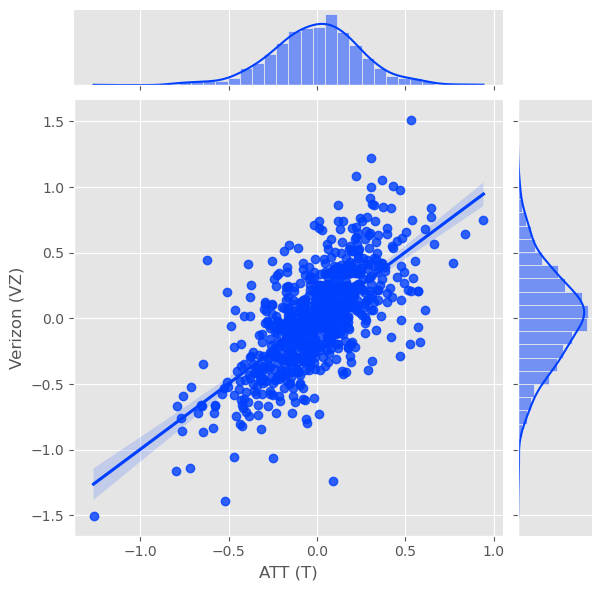

In [78]:
# sns.jointplot(x='T',y='VZ',data=telecom,kind='reg')


#or
# Create the jointplot and capture the returned JointGrid object
g = sns.jointplot(x='T', y='VZ', data=telecom, kind='reg')

# Set custom axis labels
g.set_axis_labels('ATT (T)', 'Verizon (VZ)', fontsize=12)

plt.show()

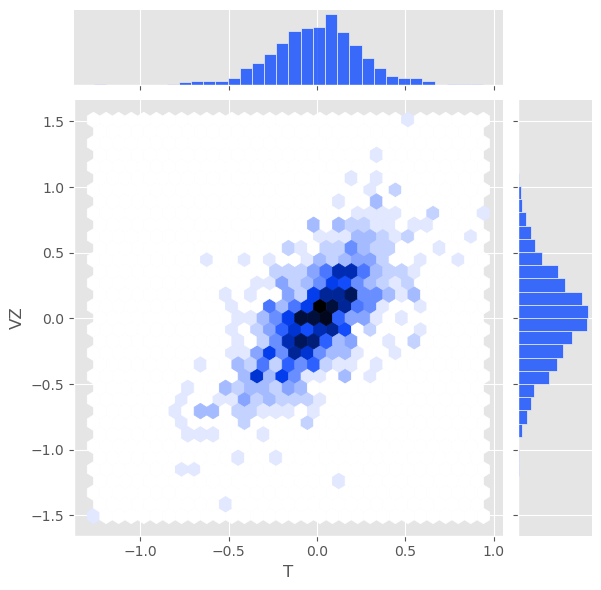

In [79]:
sns.jointplot(x='T',y='VZ',data=telecom,kind='hex')

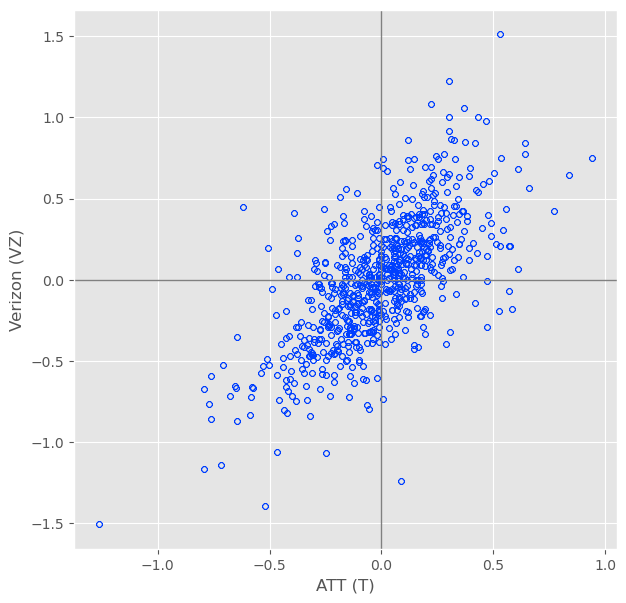

In [80]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(7, 7), marker='$\u25EF$')
'''
\u25EF is the Unicode code for the large circle character: ◯
Wrapping it in '$...$' tells Matplotlib to interpret it as a LaTeX math symbol
So marker='$\u25EF$' means: use a large hollow circle as the marker for each point in the plot.
You could have used 'o' or 'O' or even just '◯' directly for similar results, but using Unicode via LaTeX lets you precisely control shapes or even use letters, symbols, or expressions as markers.
'''
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1);

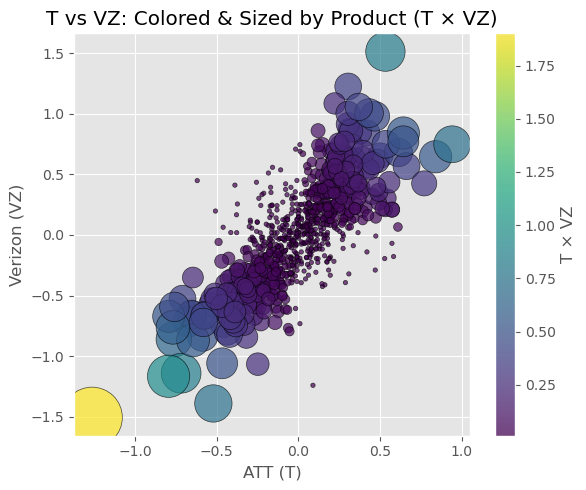

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Compute product of T and VZ
product = telecom['T'] * telecom['VZ']
product_clean = product.fillna(0).clip(lower=0.01)
'''
 What this line does:
.fillna(0):
    Replaces any NaN values (which could result from missing data in T or VZ) with 0.
.clip(lower=0.01):
        Ensures that all values are at least 0.01.
        Any value below 0.01 is replaced with 0.01.
    This is useful to avoid:
        Zero values that could mess up plot sizes (e.g., size=0 would be invisible).
        Negative values, which don’t make sense for size or color intensity in a plot.
'''

# Create scatter plot using matplotlib directly
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    telecom['T'], telecom['VZ'],
    c=product_clean,                   # Color by product
    s=product_clean * 1000,            # Size by product (adjust scaling if needed)
    cmap='viridis',                    # Colormap
    edgecolors='black',
    linewidths=0.5,
    alpha=0.7
)

# Add colorbar for product values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('T × VZ')

# Labels and title
ax.set_title('T vs VZ: Colored & Sized by Product (T × VZ)')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.grid(True)

plt.tight_layout()
plt.show()



In [82]:
import cufflinks as cf
cf.go_offline()

# Create hover text column with date labels
telecom['DateLabel'] = telecom.index.astype(str)
telecom['T_VZ'] = telecom['T'] * telecom['VZ']  # Bubble size

# Create the bubble plot
telecom.iplot(
    kind='bubble',
    x='T',
    y='VZ',
    size='T_VZ',
    text='DateLabel',         # ✅ Use column name, not a list
    xTitle='ATT (T)',
    yTitle='Verizon (VZ)',
    title='Bubble Plot: T vs VZ',
    mode='markers',
    theme='white',
    dimensions=(800, 800) 
)


## **Exploring Two or More Variables**
Load the kc_tax dataset and filter based on a variety of criteria

In [83]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498249 entries, 0 to 498248
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   TaxAssessedValue  497511 non-null  float64
 1   SqFtTotLiving     498249 non-null  int64  
 2   ZipCode           467900 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 11.4 MB


In [84]:
kc_tax['TaxAssessedValue'].mean()

473795.93824257154

In [85]:
# This code filters rows in the kc_tax DataFrame where all three conditions are true, and saves the result into a new DataFrame called kc_tax0.
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
'''
Part	                            Explanation
kc_tax.loc[...]	                    Uses .loc[] to select rows by condition
kc_tax.TaxAssessedValue < 750000	Keep only homes assessed at less than $750,000
kc_tax.SqFtTotLiving > 100	        Keep homes with more than 100 square feet of living space (eliminate bad/missing records)
kc_tax.SqFtTotLiving < 3500	        Keep homes smaller than 3,500 sq ft (remove extreme outliers)
&	                                Logical AND — all 3 conditions must be met for a row to be kept
, :	                                Means “return all columns” for the filtered rows
'''
print(kc_tax0.shape)

(432693, 3)


In [86]:
kc_tax0.head(3)

,TaxAssessedValue,SqFtTotLiving,ZipCode
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0


In [87]:
kc_tax0[['TaxAssessedValue', 'SqFtTotLiving']].corr()

,TaxAssessedValue,SqFtTotLiving
TaxAssessedValue,1.000000,0.531024
SqFtTotLiving,0.531024,1.000000


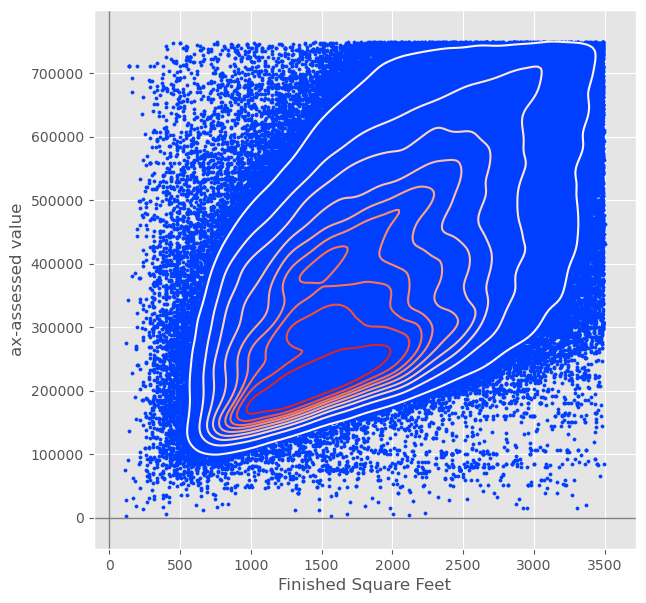

In [88]:
ax = kc_tax0.plot.scatter(x='SqFtTotLiving', y='TaxAssessedValue', figsize=(7, 7), marker='.')
'''
\u25EF is the Unicode code for the large circle character: ◯
Wrapping it in '$...$' tells Matplotlib to interpret it as a LaTeX math symbol
So marker='$\u25EF$' means: use a large hollow circle as the marker for each point in the plot.
You could have used 'o' or 'O' or even just '◯' directly for similar results, but using Unicode via LaTeX lets you precisely control shapes or even use letters, symbols, or expressions as markers.
'''
sns.kdeplot(x=kc_tax0['SqFtTotLiving'], y=kc_tax0['TaxAssessedValue'],cmap='Reds', ax=ax)
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('ax-assessed value')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1);

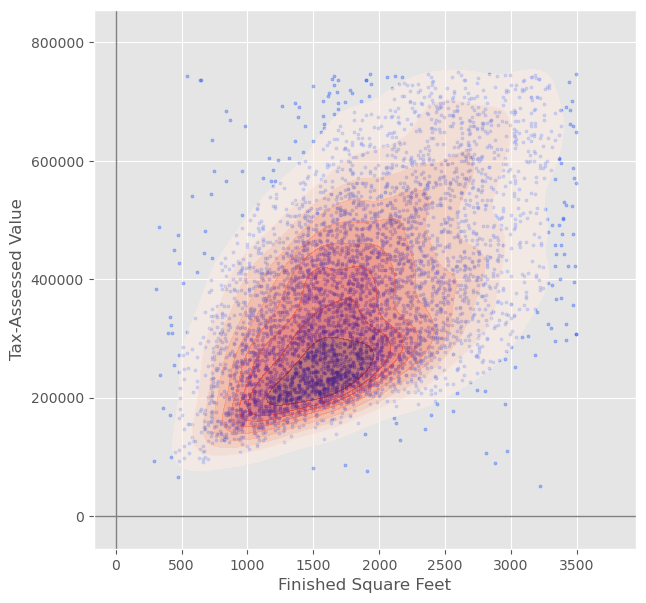

In [89]:
import seaborn as sns


sample = kc_tax0.sample(5000, random_state=42)
'''
.sample(5000): Randomly selects 5,000 rows from that DataFrame. This is useful when you want faster plotting or quick exploration without loading the entire dataset.
random_state=42: Ensures reproducibility. Using a fixed random seed (like 42) guarantees that every time you run this cell, you get the same 5,000 random rows.
'''
# Base scatter plot
ax = sample.plot.scatter(x='SqFtTotLiving', y='TaxAssessedValue', figsize=(7, 7), marker='.', alpha=0.3)

# KDE plot overlay
sns.kdeplot(
    x=sample['SqFtTotLiving'],
    y=sample['TaxAssessedValue'],
    ax=ax,
    cmap='Reds',  # Optional: colormap for the density
    fill=True,    # Optional: fill the contours
    alpha=0.5,    # Transparency of the density layer
    thresh=0.05   # Optional: threshold for drawing contours. “Only show contours where the density is at least 5% of the peak (maximum) density.”
)

# Labeling and styling
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax-Assessed Value')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1);

Text(0, 0.5, 'Tax-Assessed Value')

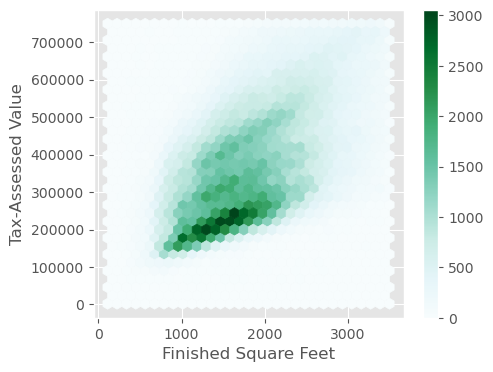

In [90]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax-Assessed Value')

## **Two Categorical Variables**

Load the lc_loans dataset

In [91]:
lc_loans = pd.read_csv(LC_LOANS_CSV)

In [92]:
lc_loans.head()

,status,grade
0,Fully Paid,B
1,Charged Off,C
2,Fully Paid,C
3,Fully Paid,C
4,Current,B


In [93]:
lc_loans['status'].value_counts()

status
Current        321185
Fully Paid      97316
Charged Off     22671
Late             9789
Name: count, dtype: int64

In [94]:
lc_loans['status'].value_counts().sum()

450961

In [95]:
lc_loans['grade'].value_counts()

grade
B    132370
C    120875
D     74277
A     72490
E     34804
F     12904
G      3241
Name: count, dtype: int64

In [96]:
# Table 1-8(1)
# In pandas, the .pivot_table() method is used to summarize and aggregate data — similar to Pivot Tables in Excel.
# .pivot_table() creates a new table by grouping data across one or more keys and applying an aggregation function (like sum, mean, count, etc.) to produce a summary.
crosstab = lc_loans.pivot_table(index='grade', columns='status', 
                                aggfunc=lambda x: len(x), margins=True)
'''
Part	                    Explanation
lc_loans	                Your original DataFrame (e.g., Lending Club loan data).
pivot_table(...)	        Used to group and summarize data (like a pivot table in Excel).
index='grade'	            Rows will be grouped by the grade of the loan (e.g., A, B, C, etc.).
columns='status'	        Columns will be grouped by status of the loan (e.g., Fully Paid, Charged Off, etc.).
aggfunc=lambda x: len(x)	This tells pandas to count the number of records in each combination of grade and status.
margins=True	            Adds an "All" row and column to show totals for each row and column (like grand totals).
'''
print(crosstab)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [97]:
crosstab['Current'].dtype

dtype('int64')

In [98]:
# Table 1-8(2)
df = crosstab.copy().loc['A':'G',:].astype(float)
'''
crosstab.copy()     – makes a copy of the table so you don't modify the original.
.loc['A':'G', :]    – selects only the loan grades A through G, ignoring the 'All' total row.
.astype(float)      – converts all values to floats so percentage calculations work properly.
'''
df.loc[:,'Charged Off':'Late'] = df.loc[:,'Charged Off':'Late'].div(df['All'], axis=0) #You're dividing each row value in the 'Charged Off' to 'Late' columns by the total row sum from the 'All' column — to get row-wise percentages.
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


In [99]:
# Assuming you already have crosstab and perc_crosstab from earlier:
# crosstab: raw counts
# perc_crosstab: row percentages

# Round the percentages for cleaner display
perc_rounded = perc_crosstab.round(3)

# Combine counts and percentages into a single string per cell
combined = crosstab.loc['A':'G', :].astype(int).astype(str) + "\n" + perc_rounded.astype(str)
'''
you can convert the float directly to a string using .astype(str) without converting to int first, like this:
combined = crosstab.loc['A':'G', :].astype(str) + "n" + perc_rounded.astype(str)
✅ But here's the difference:
👉 Without .astype(int):
If your count values are floats like 20408.0, they will be turned into strings as '20408.0', which is less clean.

👉 With .astype(int).astype(str):
You get clean '20408', without the decimal point, which looks more like a true count.
'''
# Optional: rename index/columns if needed
combined.index.name = 'Grade'
combined.columns.name = 'Status'

# This only displays it in a nice way in notebooks (optional)
from IPython.display import display, HTML
display(HTML(combined.to_html().replace("\\n", "<br>")))
'''
What it does:
    combined.to_html(): Converts the combined DataFrame into an HTML table.
    .replace("\\n", "<br>"): Replaces literal \n (which would just show up as text) with actual HTML <br> line breaks so that the count and percentage appear on separate lines in each cell when displayed in a notebook.
    display(HTML(...)): Jupyter-friendly way to render the styled table nicely.
''';


Status,Charged Off,Current,Fully Paid,Late,All
Grade,,,,,
A,15620.022,500510.69,204080.282,4690.006,724900.161
B,53020.04,938520.709,311600.235,20560.016,1323700.294
C,60230.05,889280.736,231470.191,27770.023,1208750.268
D,50070.067,532810.717,136810.184,23080.031,742770.165
E,28420.082,246390.708,59490.171,13740.039,348040.077
F,15260.118,84440.654,23280.18,6060.047,129040.029
G,4090.126,19900.614,6430.198,1990.061,32410.007


## **Categorical and Numeric Data**  
The pandas `boxplot` method takes the `by` argument that splits the data set into groups
and creates the individual boxplots

In [100]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


In [101]:
airline_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33468 entries, 0 to 33467
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pct_carrier_delay  33440 non-null  float64
 1   pct_atc_delay      33440 non-null  float64
 2   pct_weather_delay  33440 non-null  float64
 3   airline            33468 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


In [102]:
airline_stats['airline'].value_counts()

airline
Delta        9107
American     5725
Southwest    5584
United       5426
Alaska       3851
Jet Blue     3775
Name: count, dtype: int64

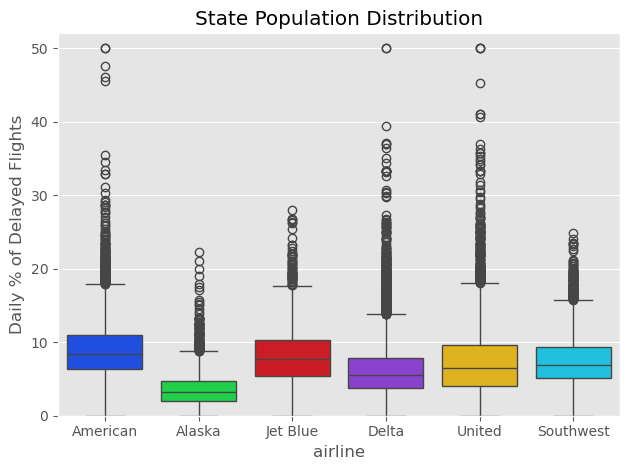

In [103]:
fig, ax = plt.subplots() 
# Create the boxplot without showing the mean
sns.boxplot(x='airline', y='pct_carrier_delay', data=airline_stats, hue='airline', showmeans=False)


# Tweak axis appearance
ax.set_xlabel('airline')
ax.set_ylabel('Daily % of Delayed Flights')
ax.set_title('State Population Distribution')
ax.set_ylim([0,52])
plt.tight_layout()
plt.show()

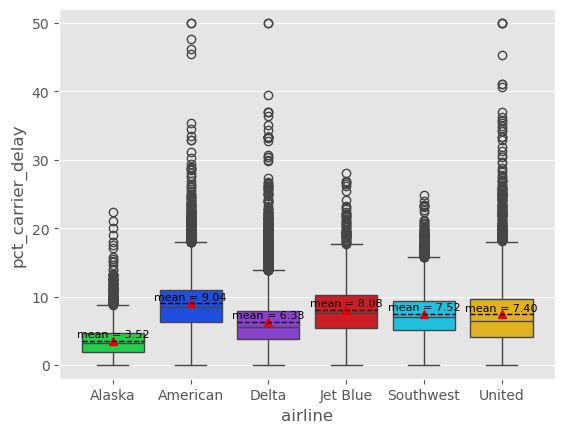

In [190]:
fig, ax = plt.subplots() 
# Compute the means per 'airline'
group_means = airline_stats.groupby("airline", observed=True)["pct_carrier_delay"].mean() #Calculates the mean pct_carrier_delay for each airline. observed=True: Only considers days that actually appear in the dataset.

# Create the boxplot without showing the mean
sns.boxplot(x='airline', y='pct_carrier_delay', data=airline_stats, hue='airline', showmeans=True, order=group_means.index)
'''
x='day': Group the data by airline ['American', 'Alaska', 'Jet Blue', 'Delta', 'United', 'Southwest'].
y='pct_carrier_delay': Plot percentage carrier delay.
hue='airline': Each box gets its own color based on the airline — although here it's redundant because hue is the same as x. Usually hue is used for a second category.
showmeans=True: Show the mean inside the box plot.
'''

#When your x-axis is categorical (like airline names), you should set the tick labels using ax.set_xticklabels() after setting the correct tick positions.
# here You don’t need to set xticks manually Since Seaborn with order=group_means.index takes care of the tick positions and labels, this part:
# ax.set_xticks(range(len(group_means)))  # numeric positions
# ax.set_xticklabels(group_means.index, rotation=45)  # your airline names


ax.set_ylim([-2,52])
## Overlay Dashed Mean Lines:
# Get the unique categories in the same order as on the x-axis
# categories = airline_stats['airline'].unique()

# Draw horizontal dashed mean lines over each box
for i, cat in enumerate(group_means.index): #print(list(enumerate(group_means.index)))      [(0, 'Alaska'), (1, 'American'), (2, 'Delta'), (3, 'Jet Blue'), (4, 'Southwest'), (5, 'United')]
    mean = group_means[cat]
    plt.hlines(y=mean, xmin=i - 0.4, xmax=i + 0.4, colors="black", linestyles="--", linewidth=1, zorder=3) #zorder controls the drawing order of plot elements — that is, which elements appear on top of others.
    plt.text(i, mean + 0.5, f"mean = {mean:.2f}", ha="center", fontsize=8)
'''
group_means.index: ['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United'].
enumerate(group_means.index): [(0, 'Alaska'), (1, 'American'), (2, 'Delta'), (3, 'Jet Blue'), (4, 'Southwest'), (5, 'United')]
For each i (position on the x-axis), it:
    -Draws a horizontal dashed line using plt.hlines(...) at the mean value.
    -Places a text label slightly above the line to display the mean.
Why xmin=i - 0.4 and xmax=i + 0.4? This ensures the line spans the width of the box plot for that day (approximate width of the box is 0.8 units).

Places a text label showing the mean value above the line.
i: x-position (centered above the box).
mean + 0.5: y-position (slightly above the dashed line).
f"mean = {mean:.2f}": formats the mean to 2 decimal places (e.g., 20.44).
ha="center": horizontally center the text above the category.
fontsize=8: makes the text smaller.
''';
# print(list(enumerate(group_means.index)))       #[(0, 'Alaska'), (1, 'American'), (2, 'Delta'), (3, 'Jet Blue'), (4, 'Southwest'), (5, 'United')]
# group_means.index   #Index(['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United'], dtype='object', name='airline')

In [174]:
group_means = airline_stats.groupby("airline", observed=True)["pct_carrier_delay"].mean()
airlines_order = group_means.index.tolist()
group_means
# airlines_order  #['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United']

airline
Alaska       3.521889
American     9.042180
Delta        6.333460
Jet Blue     8.081843
Southwest    7.521997
United       7.398833
Name: pct_carrier_delay, dtype: float64

In [182]:
print(sorted(airline_stats['airline'].unique()))


['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United']


In [183]:
print(airline_stats['airline'].value_counts())


airline
Delta        9107
American     5725
Southwest    5584
United       5426
Alaska       3851
Jet Blue     3775
Name: count, dtype: int64


In [ ]:
# Prepare the data for each group
data = [airline_stats[airline_stats["airline"] == airline]["pct_carrier_delay"] for airline in airlines_order]
# len(data)   #6
data

6

In [191]:
airline_stats.dropna(subset=['airline', 'pct_carrier_delay'])

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American
...,...,...,...,...
33463,6.186422,8.798491,1.651940,Southwest
33464,9.522167,3.591133,0.261084,Southwest
33465,9.164179,2.664179,0.343284,Southwest
33466,5.152293,1.964520,0.122817,Southwest


In [193]:
airline_stats_clean = airline_stats.dropna(subset=['airline', 'pct_carrier_delay'])
airline_stats_clean.groupby("airline", observed=True)["pct_carrier_delay"].mean()

airline
Alaska       3.521889
American     9.042180
Delta        6.333460
Jet Blue     8.081843
Southwest    7.521997
United       7.398833
Name: pct_carrier_delay, dtype: float64

In [204]:
airline_stats[airline_stats['airline']=='American'].isna().sum()

pct_carrier_delay    2
pct_atc_delay        2
pct_weather_delay    2
airline              0
dtype: int64

In [203]:
airline_stats[airline_stats['airline']=='Alaska'].isna().sum()

pct_carrier_delay    0
pct_atc_delay        0
pct_weather_delay    0
airline              0
dtype: int64

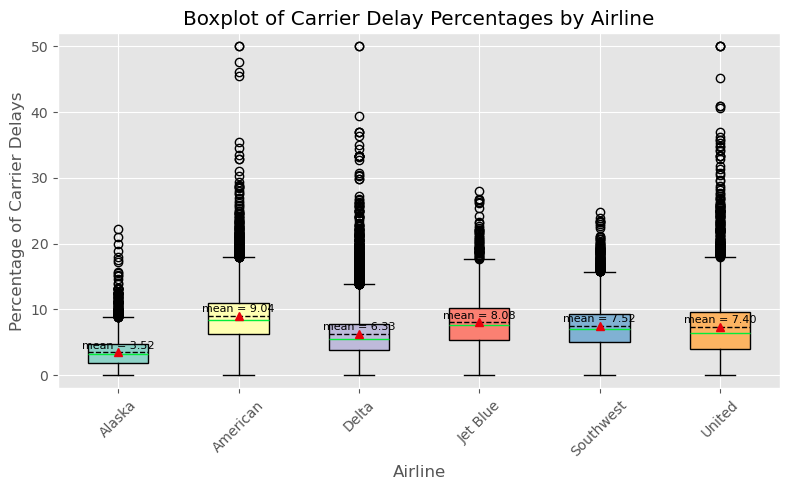

In [ ]:
# the Matplotlib-only version of your boxplot:
    # ✅ This code uses only Matplotlib for visualization.
    # ✅ It does not use Seaborn at all.
    # ✅ It avoids pandas built-in plotting methods like .plot.box() or .boxplot().
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume airline_stats DataFrame is already defined
# Drop rows with missing data in critical columns
airline_stats_clean = airline_stats.dropna(subset=['airline', 'pct_carrier_delay'])

# Get airlines in desired order by their mean delay
group_means = airline_stats_clean.groupby("airline", observed=True)["pct_carrier_delay"].mean()
airlines_order = group_means.index.tolist()

# Prepare the data for each group (ensure non-empty groups)
data = [
    airline_stats_clean[airline_stats_clean["airline"] == airline]["pct_carrier_delay"]
    for airline in airlines_order
]

# --- Plot using Matplotlib ---
fig, ax = plt.subplots(figsize=(8, 5))

# Create the boxplot
bp = ax.boxplot(data, patch_artist=True, showmeans=True)

# Customize box colors
colors = plt.cm.Set3.colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Set x-axis ticks and labels
ax.set_xticks(np.arange(1, len(airlines_order) + 1))
ax.set_xticklabels(airlines_order, rotation=45)

# Y-axis and labels
ax.set_ylim([-2, 52])
ax.set_ylabel("Percentage of Carrier Delays")
ax.set_xlabel("Airline")
ax.set_title("Boxplot of Carrier Delay Percentages by Airline")

# Add horizontal dashed mean lines and text annotations
for i, airline in enumerate(airlines_order):
    mean = group_means[airline]
    ax.hlines(y=mean, xmin=i + 0.75, xmax=i + 1.25, color='black', linestyle='--', linewidth=1)
    ax.text(i + 1, mean + 0.5, f"mean = {mean:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


In [163]:
airline_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33468 entries, 0 to 33467
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pct_carrier_delay  33440 non-null  float64
 1   pct_atc_delay      33440 non-null  float64
 2   pct_weather_delay  33440 non-null  float64
 3   airline            33468 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


In [ ]:
df = pd.DataFrame({
    'Date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02'],
    'Product': ['A', 'B', 'A', 'B'],
    'Sales': [100, 200, 150, 300]
})
#Using .pivot() — Only works when index-column combinations are unique
df.pivot(index='Date', columns='Product', values='Sales')

Product,A,B
Date,,
2023-01-01,100,200
2023-01-02,150,300


In [222]:
#  Using .pivot_table() — Can aggregate duplicates
df_dup = pd.concat([df, pd.DataFrame([{'Date': '2023-01-01', 'Product': 'A', 'Sales': 50}])], ignore_index=True)
pivot_table_result = df_dup.pivot_table(index='Date', columns='Product', values='Sales', aggfunc='sum')
print(pivot_table_result)


Product       A    B
Date                
2023-01-01  150  200
2023-01-02  150  300


In [219]:
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


In [168]:
pivot_df = airline_stats.pivot(columns='airline', values='pct_carrier_delay')
pivot_df

airline,Alaska,American,Delta,Jet Blue,Southwest,United
0,NaN,8.153226,NaN,NaN,NaN,NaN
1,NaN,5.959924,NaN,NaN,NaN,NaN
2,NaN,7.157270,NaN,NaN,NaN,NaN
3,NaN,12.100000,NaN,NaN,NaN,NaN
4,NaN,7.333333,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
33463,NaN,NaN,NaN,NaN,6.186422,NaN
33464,NaN,NaN,NaN,NaN,9.522167,NaN
33465,NaN,NaN,NaN,NaN,9.164179,NaN
33466,NaN,NaN,NaN,NaN,5.152293,NaN


In [171]:
pivot_df.columns.tolist()

['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United']

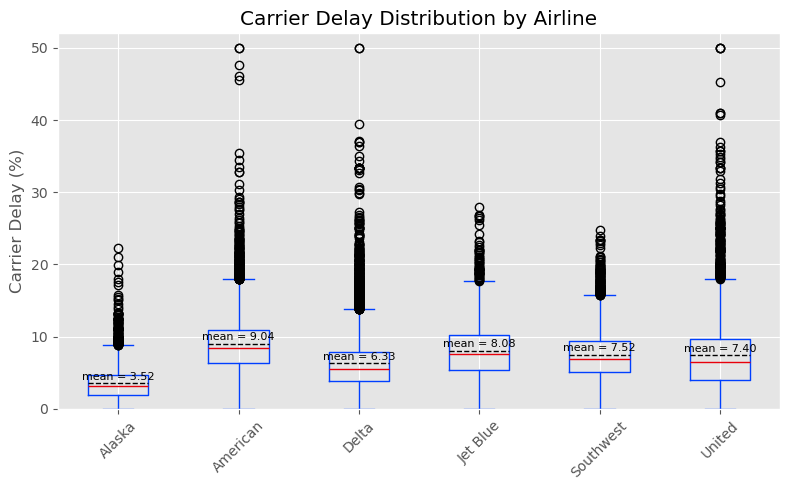

In [ ]:
# Step 1: Pivot the data so each airline becomes a column
pivot_df = airline_stats.pivot(columns='airline', values='pct_carrier_delay')
airlines_order = pivot_df.columns.tolist()  #['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United']
# Step 2: Plot the boxplot
pivot_df.plot.box(figsize=(8, 5))
#or
# pivot_df.plot(kind = 'box', figsize=(8, 5))
# Optional formatting
import matplotlib.pyplot as plt
plt.ylabel('Carrier Delay (%)')
plt.title('Carrier Delay Distribution by Airline')
plt.ylim([0, 52])
plt.xticks(rotation=45)
plt.grid(True)
# Add mean lines and annotations
for i, airline in enumerate(airlines_order):
    mean = group_means[airline]
    plt.hlines(y=mean, xmin=i + 0.75, xmax=i + 1.25, color='black', linestyle='--', linewidth=1)
    plt.text(i + 1, mean + 0.5, f"mean = {mean:.2f}", ha="center", fontsize=8)

'''
✅ .plot.box() → uses Matplotlib under the hood (🔹 No groupby capability.)
This is a high-level method that calls Matplotlib and produces a boxplot for numeric columns in the DataFrame. 
It’s shorthand for DataFrame.plot(kind='box').

✅ .boxplot() → uses pandas’ own internal logic
This is a more flexible method specifically for creating boxplots. It can group by a column, select subsets, etc.

✅ .plot.box() is a pandas built-in plotting method.
It uses Matplotlib under the hood and is accessed via the plot accessor.

✅ .boxplot() is also a pandas built-in function but not via the plot accessor.
It is a higher-level method tailored specifically for boxplots with options to group by columns or indices.
'''
plt.tight_layout()
plt.show()


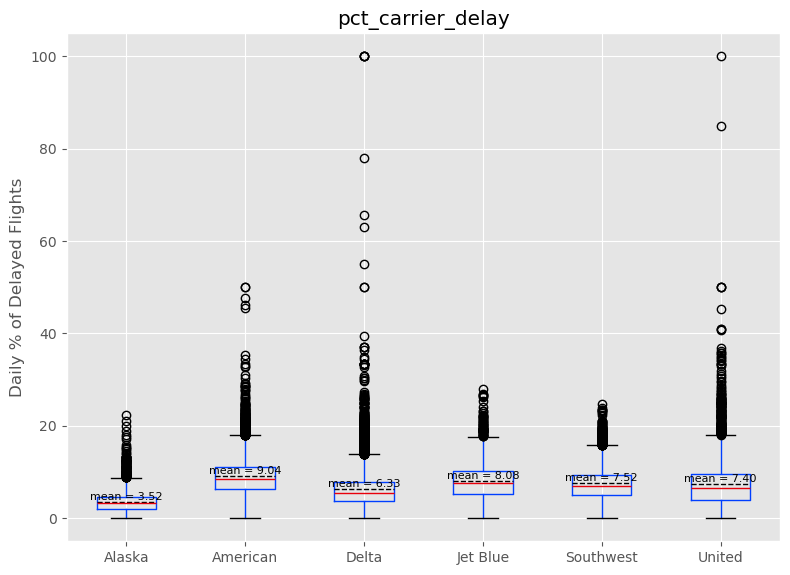

In [ ]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay', figsize=(8, 6)) # Groups the data by the 'airline' column.
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')
pivot_df = airline_stats.pivot(columns='airline', values='pct_carrier_delay')
airlines_order = pivot_df.columns.tolist()
# Add mean lines and annotations
for i, airline in enumerate(airlines_order):
    mean = group_means[airline]
    plt.hlines(y=mean, xmin=i + 0.75, xmax=i + 1.25, color='black', linestyle='--', linewidth=1)
    plt.text(i + 1, mean + 0.5, f"mean = {mean:.2f}", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

(-4.0, 52.0)

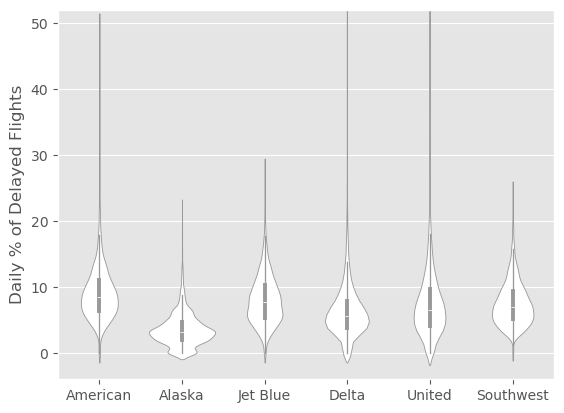

In [ ]:
ax = sns.violinplot(x = 'airline', y = 'pct_carrier_delay', data = airline_stats, color='white')
'''
This creates a violin plot, which is a combination of:
    A kernel density estimate (KDE) plot mirrored on both sides (like a violin),
    A boxplot summary (if inner is specified).
What happens if you add inner='quartile':
    This will draw horizontal lines inside each violin to show the 25th percentile, median (50th percentile), and 75th percentile.
    It's similar to seeing a boxplot embedded within the violin.
'''
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
ax.set_ylim([-4, 52])

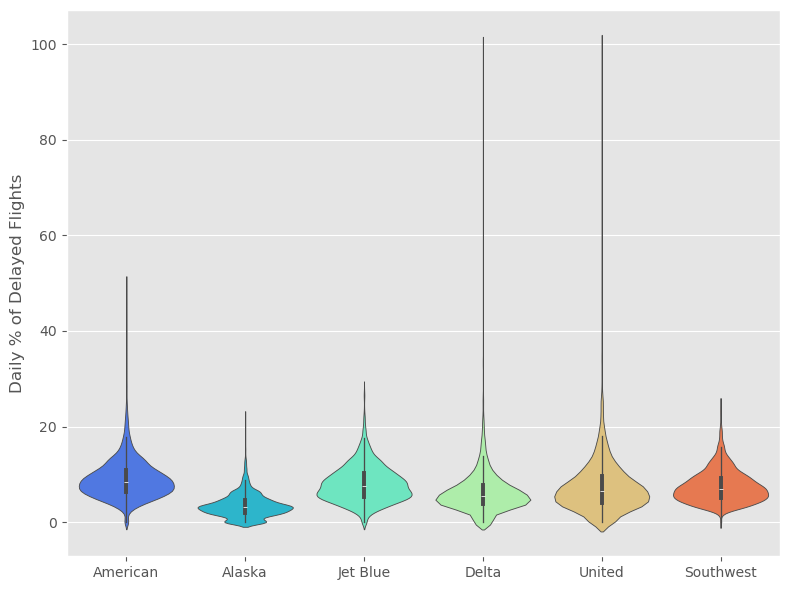

In [240]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=airline_stats, x = 'airline', y = 'pct_carrier_delay',
               ax=ax, hue="airline", palette='rainbow')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

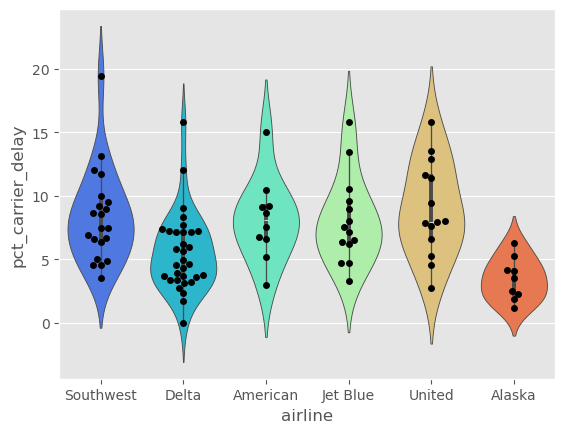

In [237]:
sample = airline_stats.sample(100, random_state=42)

sns.violinplot(x = 'airline', y = 'pct_carrier_delay', data = sample, hue="airline", palette='rainbow')
sns.swarmplot(x = 'airline', y = 'pct_carrier_delay', data = sample, color='black');

## **Visualizing Multiple Variables**

In [241]:
kc_tax0.head()

,TaxAssessedValue,SqFtTotLiving,ZipCode
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
5,223000.0,1570,98032.0


In [243]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax0.loc[kc_tax0['ZipCode'].isin(zip_codes),:]

,TaxAssessedValue,SqFtTotLiving,ZipCode
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
10,202000.0,830,98108.0
11,210000.0,1130,98108.0
12,193000.0,1560,98108.0
...,...,...,...
498049,346000.0,1430,98105.0
498050,463000.0,1610,98105.0
498051,553000.0,1580,98105.0
498052,571000.0,1840,98105.0


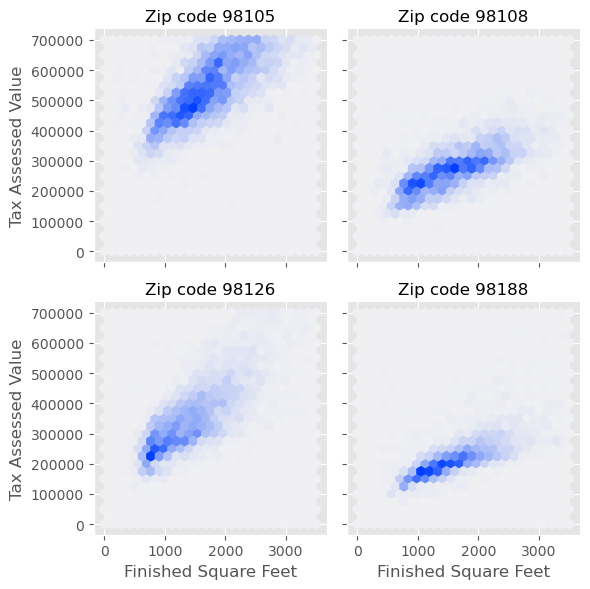

In [244]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0['ZipCode'].isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()

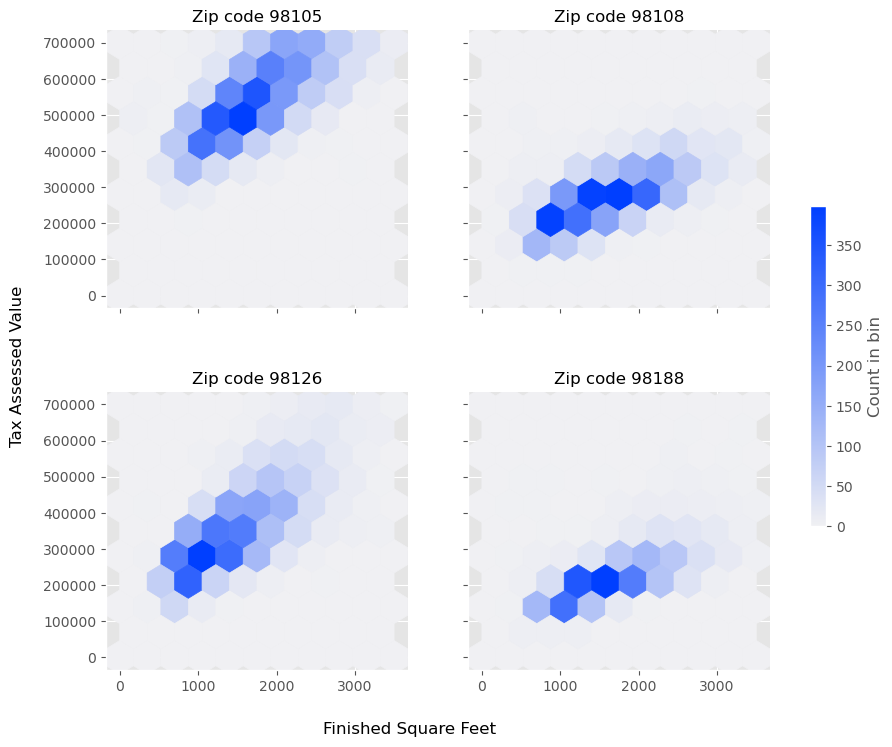

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0['ZipCode'].isin(zip_codes), :] #Filters the kc_tax0 DataFrame to include only rows where ZipCode is one of those in zip_codes.
'''
.isin() always returns a Boolean Series – not the data itself.
It checks whether each element in a Series is contained in a list, set, or another Series, and returns a Boolean Series of the same length.
This result can then be used to filter the original DataFrame:  kc_tax0.loc[kc_tax0['ZipCode'].isin(zip_codes), :]
'''


def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)
'''
This function draws a hexbin plot using plt.hexbin():
    x, y: numeric variables to plot (passed automatically by FacetGrid.map(). x, y: the columns 'SqFtTotLiving' and 'TaxAssessedValue' for each zip code.).
    color: used to create a light colormap (cmap).
    gridsize=25: defines how many hexagons per row.
    **kwargs: lets Seaborn pass additional options like extent.
'''



# Create FacetGrid
g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2, height=4) #“I want a grid of plots (small multiples), one for each unique ZipCode, arranged in 2 columns.”
'''
Creates a grid of subplots:
    col='ZipCode': one plot per zip code.
    col_wrap=2: 2 plots per row.
    height=4: each subplot is 4 inches tall (and wide, unless changed).
'''
hb = g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', extent=[0, 3500, 0, 700000])
'''
.map() applies a plotting function (in this case hexbin) to each subset of your data — one subset per subplot (i.e., one per zip code).
Think of .map() as:
    "For each small subplot, apply hexbin to the corresponding data slice."
Applies your hexbin function to each facet in the grid.
extent: defines [xmin, xmax, ymin, ymax] for consistent axes across plots.

1. Subset (of data):
A subset is a portion of your dataset, filtered by some condition. In Seaborn's FacetGrid, each plot is made from a subset of the data.
2. Subplot:
A subplot is a smaller plot inside a figure. You can arrange multiple subplots into a grid to compare different views.
'''

# Remove individual axis labels
g.set_axis_labels("", "")
g.set_titles("Zip code {col_name:.0f}")
'''
Custom title for each subplot.
col_name is replaced with the value of the ZipCode in each facet.
'''

# Adjust subplot spacing
g.figure.subplots_adjust(top=0.92, bottom=0.12, left=0.12, right=0.95, hspace=0.3, wspace=0.2)

# Add shared axis labels

g.figure.text(0.5, 0.04, 'Finished Square Feet', ha='center', fontsize=12)
g.figure.text(0, 0.5, 'Tax Assessed Value', va='center', rotation='vertical', fontsize=12)
# Add colorbar using the first hexbin object
cbar_ax = g.figure.add_axes([1, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
plt.colorbar(hb.axes[0].collections[0], cax=cbar_ax, label='Count in bin')
'''
Adds a colorbar to the right of the figure.
add_axes() manually defines the colorbar position on the canvas.
collections[0] accesses the actual hexbin object to link to the color scale.
label='Count in bin': adds a label to the colorbar.
'''
plt.show()
